# **1. Setup e imports**

In [136]:
%run notebook_setup.py

# garante que todos os módulos importados sejam recarregados automaticamente antes de cada execução de célula.
%load_ext autoreload
# O número 2 significa: Recarregue automaticamente todos os módulos importados antes da execução de qualquer célula.
%autoreload 2

[ERRO] Pasta 'src' não encontrada a partir de c:\ESTUDO\ST_PAULO\projeto_analise_series_temporais\notebooks
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# !pip install "numpy>=1.22,<1.26" "scipy<1.16" "pmdarima==2.0.4"

In [138]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import statsmodels.tsa.api as smt

import pmdarima as pm
from pmdarima import utils
from pmdarima.pipeline import Pipeline

from pathlib import Path

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter('ignore', np.RankWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# from backend.preprocessing import aplicar_log, diferenciar, reverter_transformacoes
from backend.stats_tests import teste_adf
from backend.preprocessing import split_series_treino_teste
from backend.visualization import (
    plot_acf_pacf, plot_annual_trend, 
    plot_full_time_series, plot_train_test_split
)

from backend.residuals import (
    calc_residuo_mm, plot_mm_e_residuo,
    calc_residuo_ewm, plot_ewm_e_residuo
)

from backend.arima_model import (
    rodar_modelo_arima
)



In [139]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# **2. Carregamento dos Dados**

Nesta etapa inicial, será realizado o carregamento do dataset a partir de um arquivo CSV.

O dataset contém informações sobre o índice **IPCA** [IBGE - Instituto Brasileiro de Geografia e Estatística)](https://www.ipeadata.gov.br/Default.aspx) que representa a **Índice Nacional de Preços ao Consumidor Amplo (IPCA) que é usado para indicar se os preços  estão subindo (inflação), caindo (deflação) ou estáveis. Ele mede a variação dos preços de uma cesta de produtos e serviços para o consumidor final no Brasil**.

Principais características do índice:
- É um índice da taxa de variação do IPCA dos serviços, com ano-base em 1992.
- Mede a inflação de um conjunto de bens e serviços comercializados no varejo, referentes ao consumo pessoal das famílias no Brasil.
- É uma série temporal mensal, não ajustada sazonalmente (Not Seasonally Adjusted)

A base de dados é composta por duas colunas principais:
- **Data**: representa o período de observação, em formato de data.
- **Índice (IPCA)**: variável numérica que expressa o taxa de variação mensal, em relação ao ano de referência (1992 - 2025).

In [140]:
caminho_dataset = Path('../data/raw/IPCA1992A2025.csv')

df = pd.read_csv(caminho_dataset,header=0,
                 sep=';',
                 decimal=',',
                 parse_dates=['observation_date'],  # converte automaticamente para datetime
                 dayfirst=False,                    # formato ano/mês - não tem dia
                 index_col='observation_date')   
df = df.drop(columns=['Unnamed: 2'])

titulo_da_serie = "Varaição do taxa do índice IPCA no Brasil"
coluna_numerica = "ipca" # coluna com o valor numérico da série

# **3. Visualizar a série**

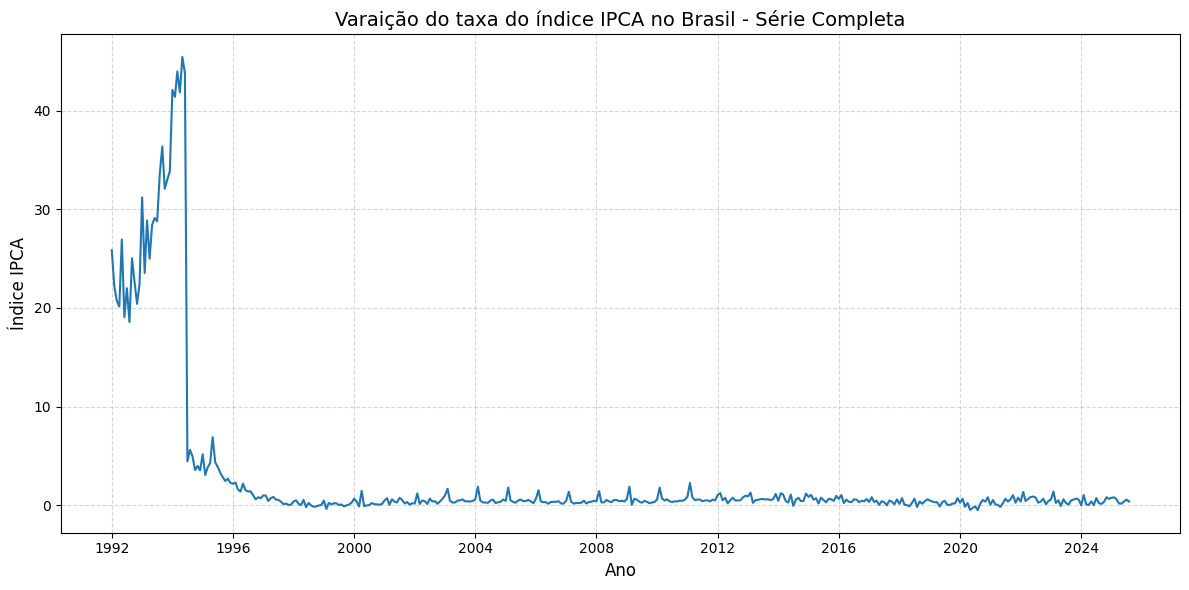

In [141]:
plot_full_time_series(
    df[[coluna_numerica]],
    title=f"{titulo_da_serie} - Série Completa",
    xlabel="Ano",
    ylabel="Índice IPCA"
)


**No período de 1992 até 1995 é possível verificar uma grande variação da taxa do IPCA. Evento marcado por uma hiperinflação crônica e as tentativas definitivas de controlá-la. Esse período foi marcado pelo governo Collor, que implementou um plano radical (Plano Collor), que entre outras medidas, confiscou a poupança financeira da população para reduzir a quantidade de dinheiro em circulação. Ainda nesse período ocorreu o processo de impeachment do Presidente Fernando Collor, afastado por corrupção em dezembro. Assume o vice, Itamar Franco. O Brasil começa a melhorar em 1994 através da implementação do Plano Real (julho). A qual gerou queda espetacular da inflação no 2º semestre. Em 1995 o Brasil consegue a estabilidade da inflação para patamares "normais".**

Sendo assim, foi realizado o tratamento dos dados para pegar a série do período de 1998 até Agosto de 2025.

In [142]:
df_1998_to_2025 = df[df.index.year >= 1998]
df = df_1998_to_2025



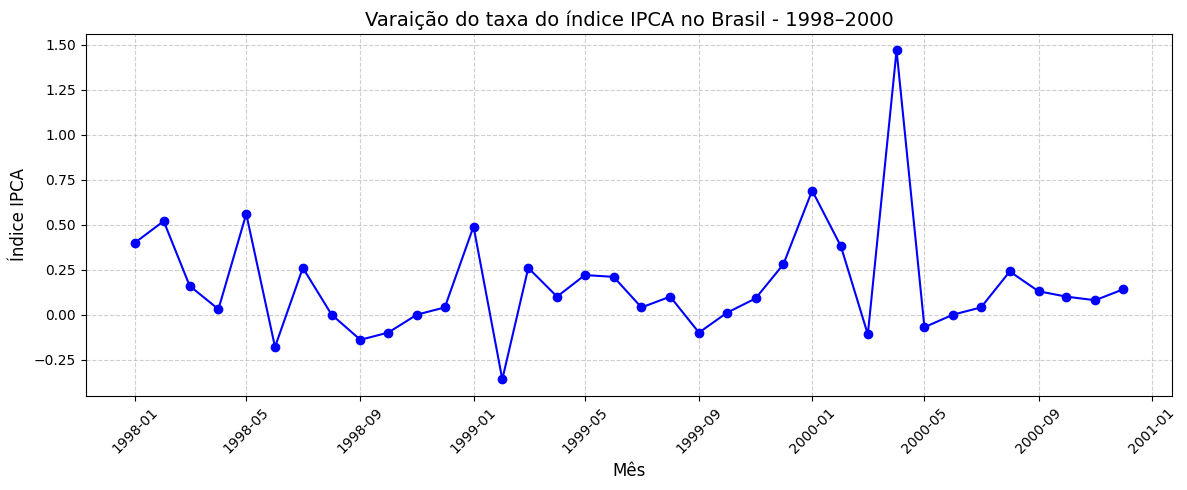

In [143]:
plot_annual_trend(
    df,
    column=coluna_numerica,
    year=(1998,2000),
    title=titulo_da_serie,
    xlabel="Mês",
    ylabel="Índice IPCA"
)

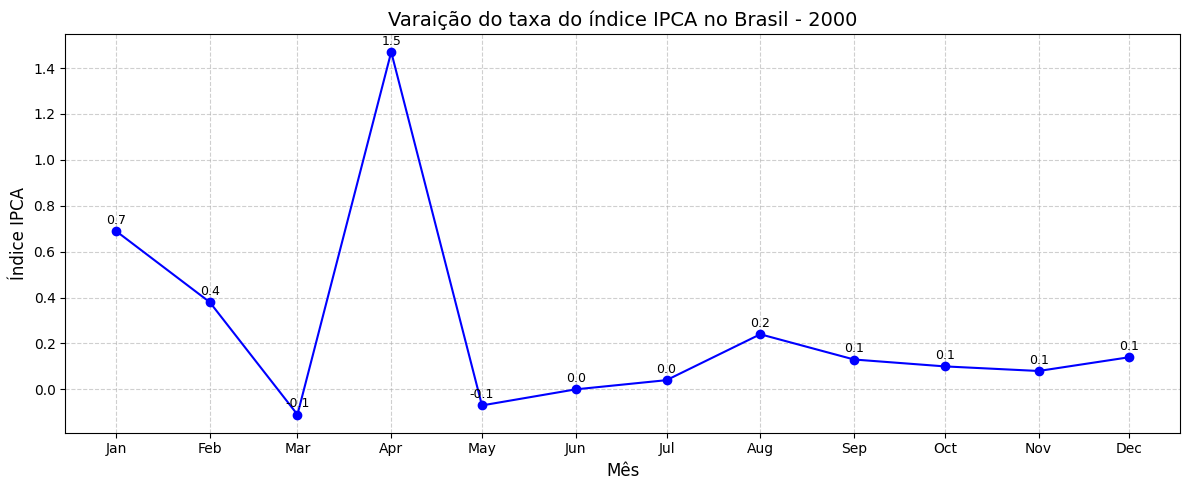

In [144]:
plot_annual_trend(
    df,
    column=coluna_numerica,
    year=(2000),
    title=titulo_da_serie,
    xlabel="Mês",
    ylabel="Índice IPCA"
)

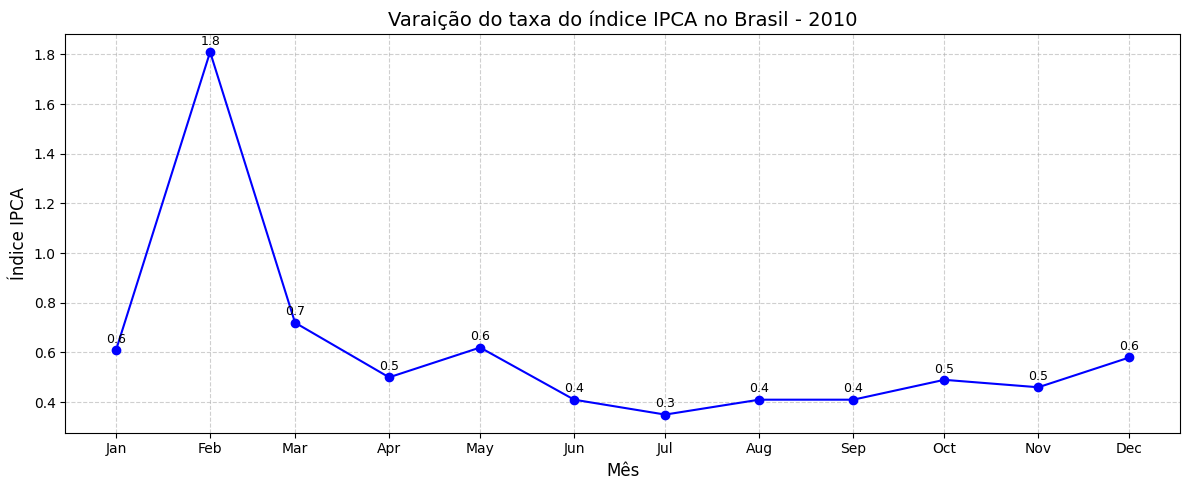

In [145]:
plot_annual_trend(
    df,
    column=coluna_numerica,
    year=2010,
    title=titulo_da_serie,
    xlabel="Mês",
    ylabel="Índice IPCA"
)

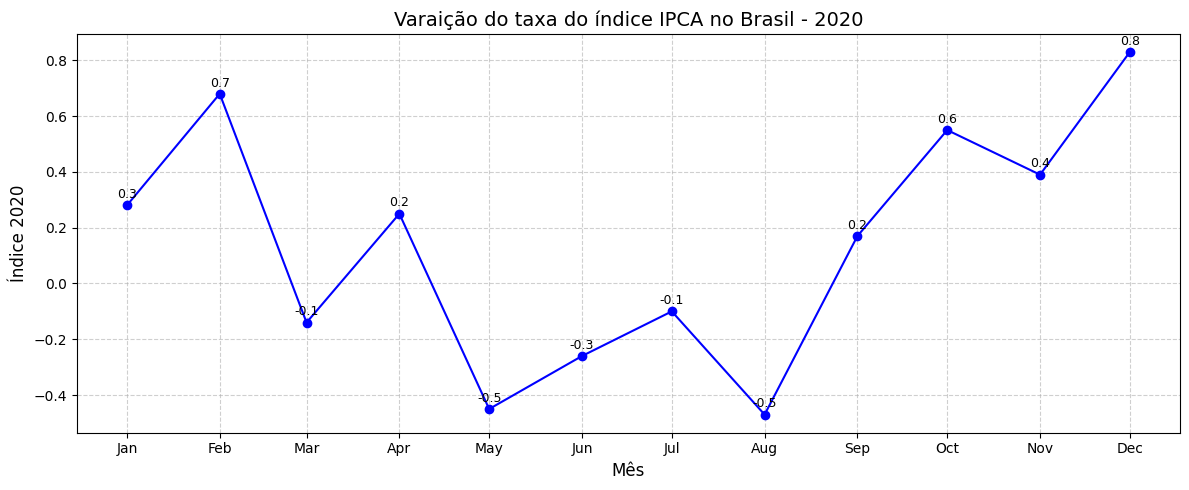

In [146]:
plot_annual_trend(
    df,
    column=coluna_numerica,
    year=2020,
    title=titulo_da_serie,
    xlabel="Mês",
    ylabel="Índice 2020"
)

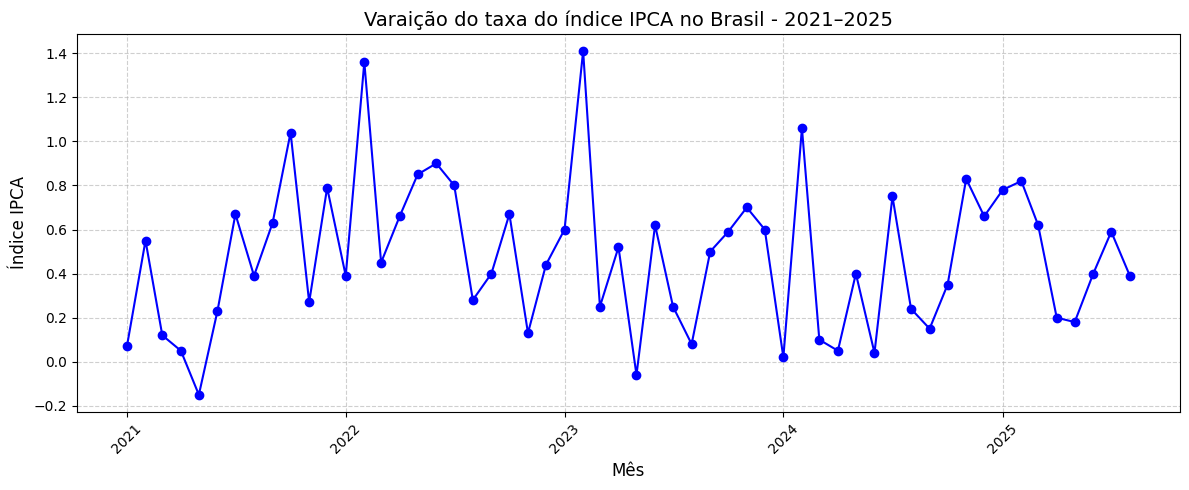

In [148]:
plot_annual_trend(
    df,
    column=coluna_numerica,
    year=(2021, 2025),
    title=titulo_da_serie,
    xlabel="Mês",
    ylabel="Índice IPCA"
)

## **3.1. Visualizar os componentes da série**

Aqui a decomposição foi feita com a biblioteca `pmdarima`

Text(0.5, 1.0, 'Varaição do taxa do índice IPCA no Brasil - Decomposição da Série')

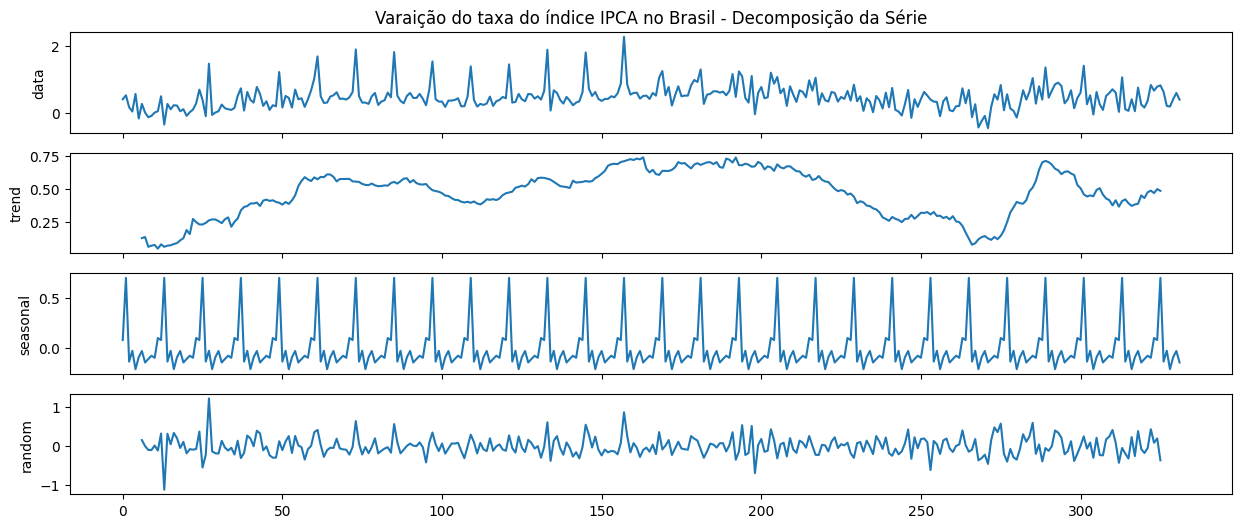

In [149]:
figure_kwargs = {'figsize': (15, 6)}  #
# Decompose the airpassengers dataset into trend, seasonal and random parts.
decomposed = pm.decompose(df.values.reshape(-1),
                             'additive', m=12)

# Plot the decomposed signal of airpassengers as a subplot

axes = utils.decomposed_plot(decomposed, figure_kwargs=figure_kwargs,
                             show=False)
axes[0].set_title(f"{titulo_da_serie} - Decomposição da Série")

<span style="color:#FFD700;">**OBSERVAÇÃO**</span>: Já é possível observar que a série tem **tendência** e **sazonalidade**, mas ainda é preciso testar a estacionariedade da série.

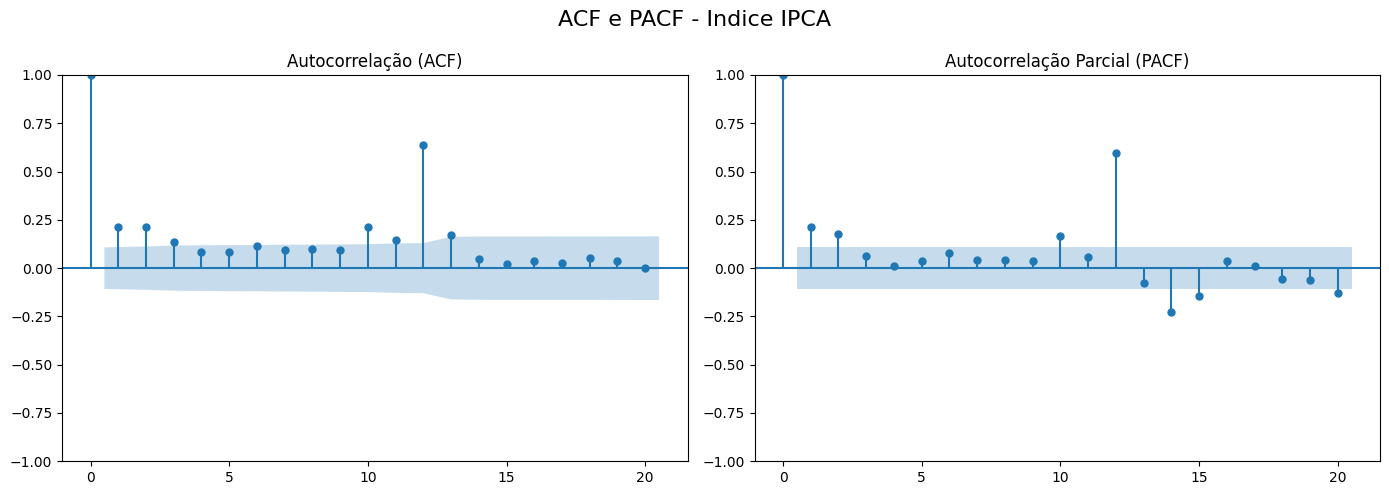

In [154]:
plot_acf_pacf(df[coluna_numerica], lags=20, title="ACF e PACF - Indice IPCA")

In [151]:
df

ipca
observation_date      
1998-01-01        0.40
1998-02-01        0.52
1998-03-01        0.16
1998-04-01        0.03
1998-05-01        0.56
...                ...
2025-04-01        0.20
2025-05-01        0.18
2025-06-01        0.40
2025-07-01        0.59
2025-08-01        0.39

[332 rows x 1 columns]

In [152]:
plot_full_time_series(
    df[[coluna_numerica]],
    title=f"{titulo_da_serie} - Série 1998 a 2025",
    xlabel="Ano",
    ylabel="Índice IPCA"
)


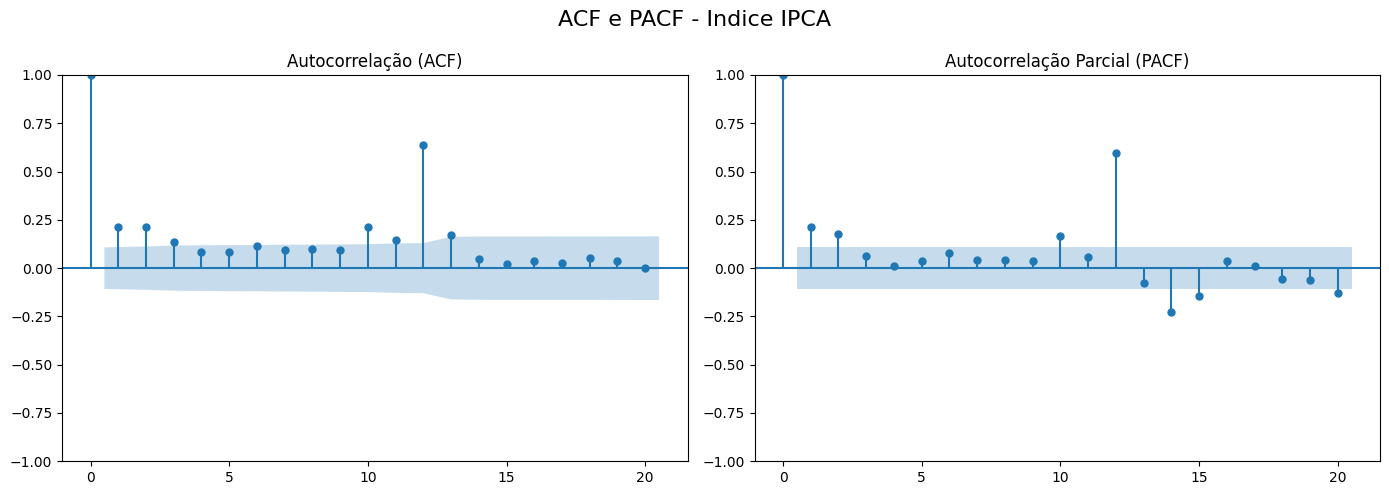

In [155]:
plot_acf_pacf(df[coluna_numerica], lags=20, title="ACF e PACF - Indice IPCA")

In [156]:
caminho_dataset = Path('../data/processed/IPCA_1992_to_2025.csv')


df_1998_to_2025_resetado = df.reset_index()


df_1998_to_2025_resetado.to_csv(caminho_dataset, index=False)

df_1998_to_2025 = df

# **4. Testar a estacionariedade da série**

Uma série temporal é estacionária se suas propriedades estatísticas (média, variância e autocorrelação) não mudam ao longo do tempo.

Uma `série temporal estacionária `
- Não possui tendência 
- Nem sazonalidade

**Aplicar o teste de Dickey-Fuller**

In [157]:
resultado = teste_adf(df_1998_to_2025)

Série é estacionária (p-valor=0.0381)
ADF Statistic: -2.9668797710213566
Critical Values:
	1%: -3.451
	5%: -2.871
	10%: -2.572


<span style="color:#FFD700;">**RESULTADO**</span>: Como p-valor do teste de Dickey-Fuller é menor que *0.05* a série <span style="color:red;">*é estacionária* </span>, sendo assim, é possível aplicar modelos clássicos como **AR**, **MA**, **ARMA** diretamente, pois exigem que a série a ser modelada seja **estacionária** (média, variância e autocorrelação constantes ao longo do tempo).



# **5. Modelagem (AR, MA, ARIMA) sem a eliminação de tendência e sazonalidade**

## **5.1. Dividir os dados em treinamento e teste**

Em virtude da série já ser estacionária não se faz necessário a eliminação da tendência e sazonalidade. Sendo assim, é possível seguir para aplicação do modelo.

In [168]:
df_1998_to_2025

ipca
observation_date      
1998-01-01        0.40
1998-02-01        0.52
1998-03-01        0.16
1998-04-01        0.03
1998-05-01        0.56
...                ...
2025-04-01        0.20
2025-05-01        0.18
2025-06-01        0.40
2025-07-01        0.59
2025-08-01        0.39

[332 rows x 1 columns]

In [169]:
# Sem validação
y_train, y_test = split_series_treino_teste(df_1998_to_2025, percentual_treino=0.75)

plot_train_test_split(df_1998_to_2025, y_train, y_test)

Série com 332 registros dividida em:
Treino (75%): 249
Teste (25%): 83


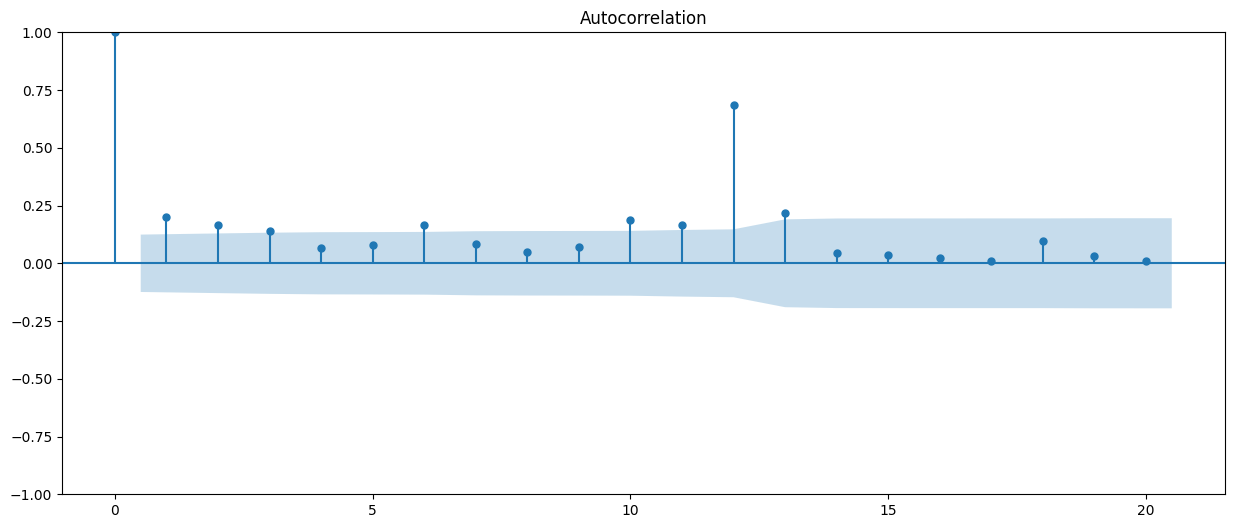

In [170]:
smt.graphics.plot_acf(y_train, lags=20)
plt.show()

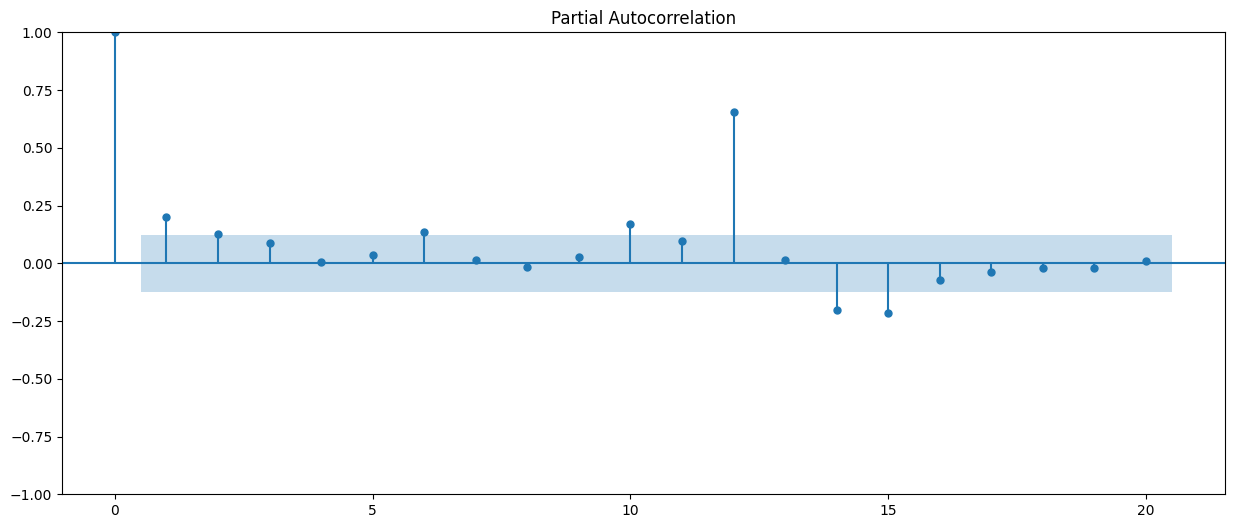

In [172]:
smt.graphics.plot_pacf(y_train, lags=20)
plt.show()

Observando que o acf e pacf observa-se que a quantidade de lags no acf é de 3 lags e o pacf é de 2 lags. Lembrando que essas informações são essencias para os modelos AR,MA,ARMA e ARIMA. O acf vai direcionar o "q" que corresponde ao MA e o pacf representa o "p" do AR.

## **5.2. Aplicar o modelo**

Embora se saiba que a série em questão não é estacionária, o que inviabiliza o uso adequado de modelos puramente AR (Auto-Regressivo), MA (Médias Móveis) e ARMA (Auto-Regressivo com Médias Móveis), esses modelos foram ainda assim aplicados.

O objetivo da execução foi ilustrar como esses modelos se comportam diante de uma série não-estacionária.

### **5.2.1. Modelo AR**

**pcaf** -> 2 lags referente a variável **"p"** que corresponde a parte autoregressiva do modelo AR e no modelo ARIMA.

#### **5.2.1.1. AR(1)**

Rodando AR(1) com order=(1, 0, 0) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


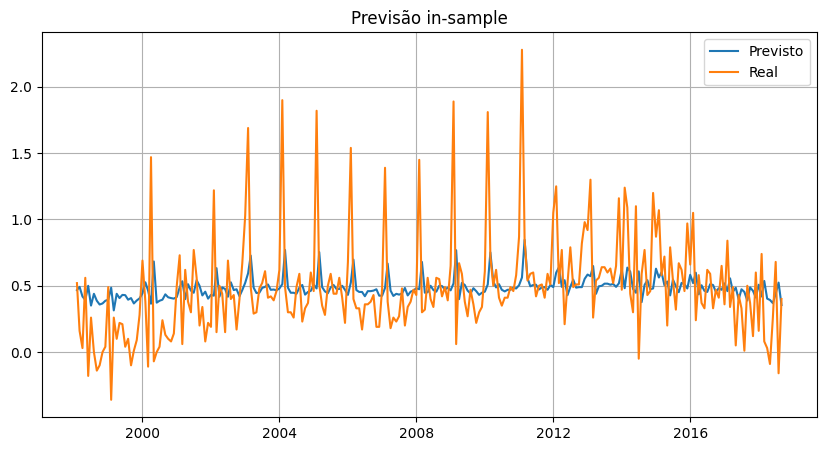


Etapa 3 - Análise de Resíduos In-Sample


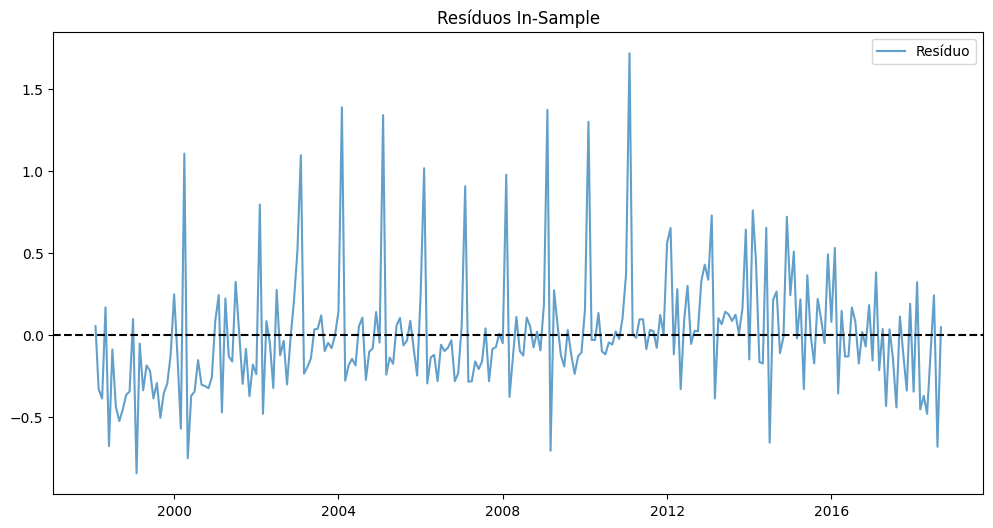

Média: 0.0004, Desvio-padrão: 0.3717

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=18.4281, p-valor=0.0482 → Autocorrelação detectada
Lag 20: estatística=139.0084, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

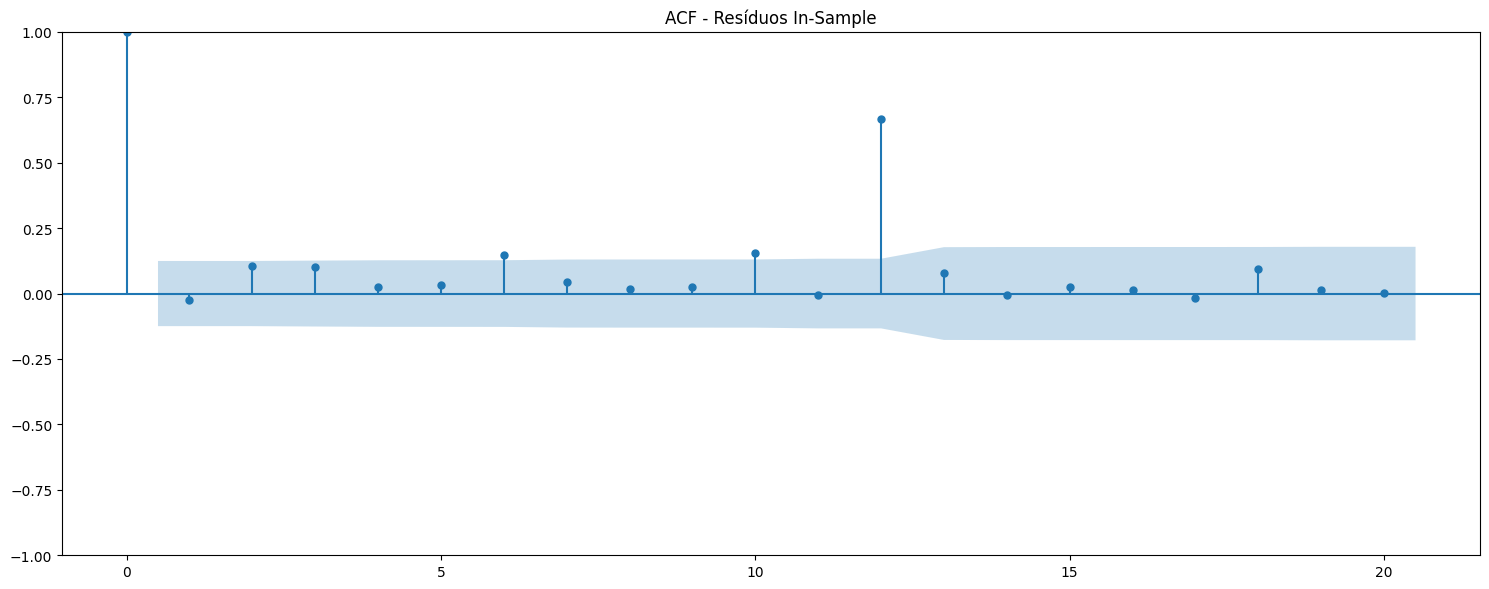


Etapa 4 - Previsões Out-of-Sample


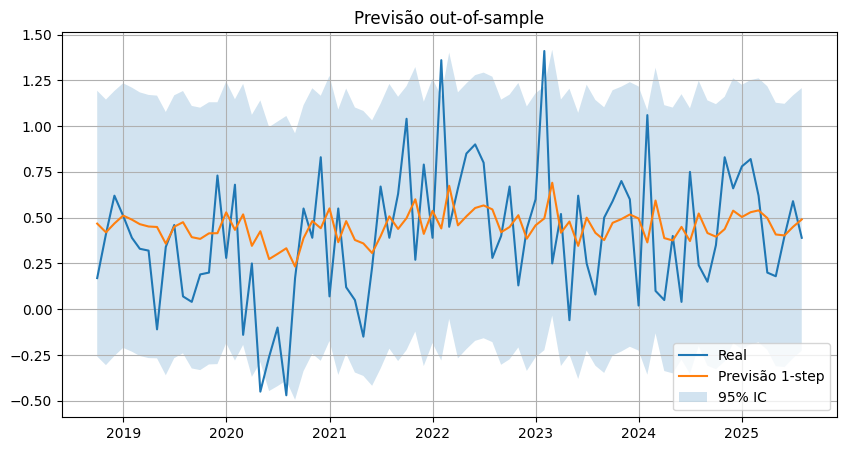


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2827
MAPE: 1.7714
MSE: 0.1232

Etapa 6 - Análise de Resíduos Out-of-Sample


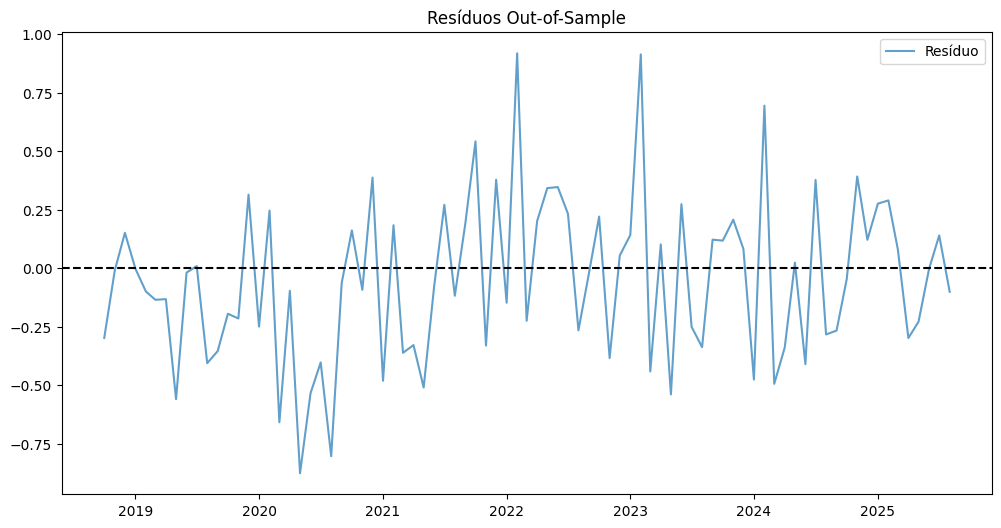

Média: -0.0532, Desvio-padrão: 0.3491

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=21.8316, p-valor=0.0160 → Autocorrelação detectada
Lag 20: estatística=48.4444, p-valor=0.0004 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

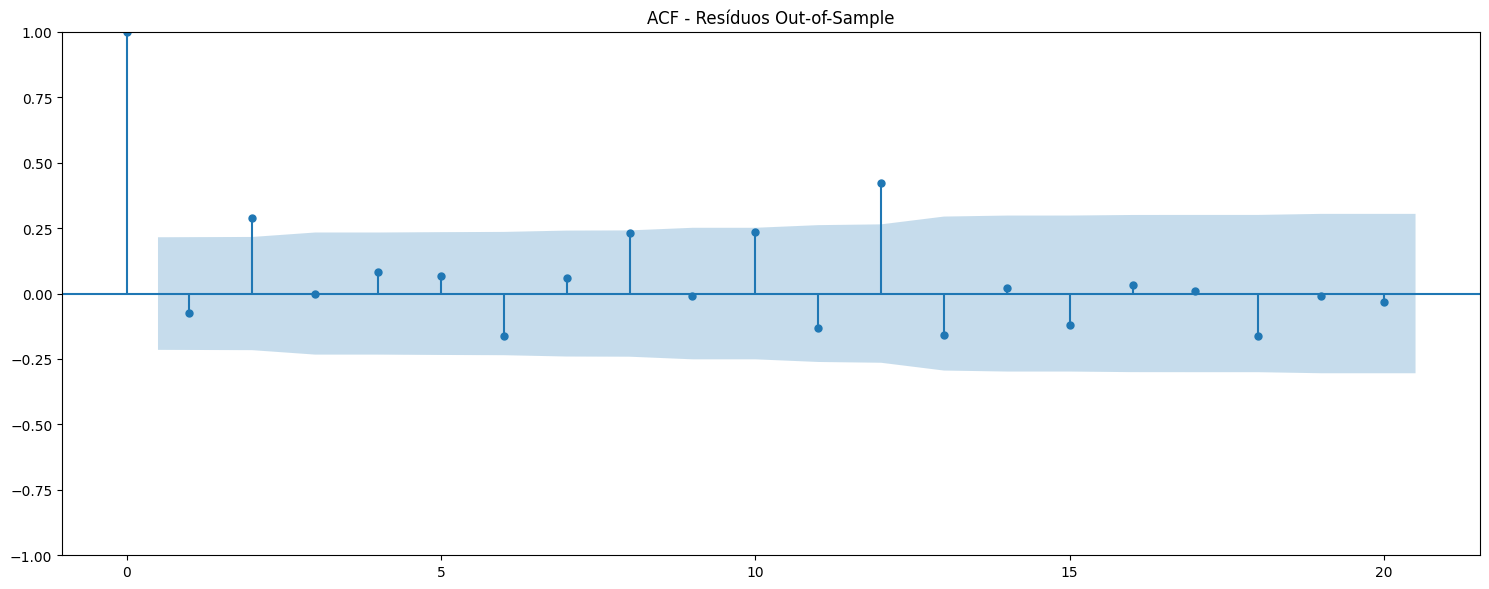


Pipeline finalizado!
Tempo total de execução: 0.03 minutos


In [176]:
resultado_ar_2 = rodar_modelo_arima(y_train, y_test, order=(1,0,0), nome_modelo="AR(1)")

#### **5.2.1.2. AR(2)**

Rodando AR(2) com order=(2, 0, 0) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


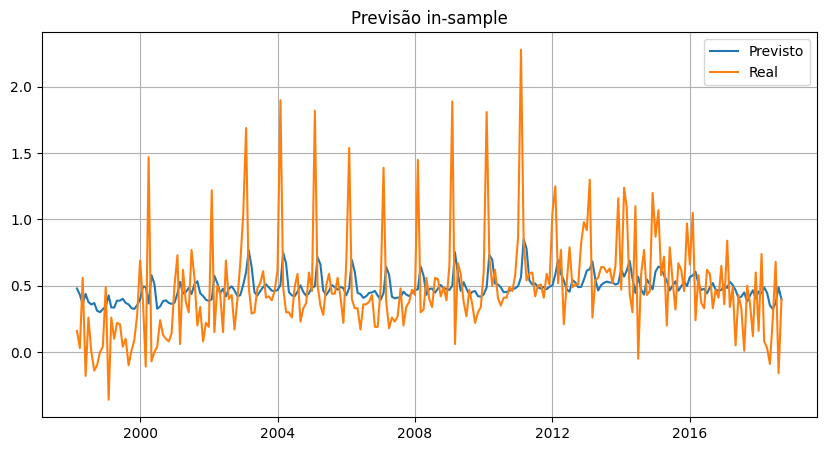


Etapa 3 - Análise de Resíduos In-Sample


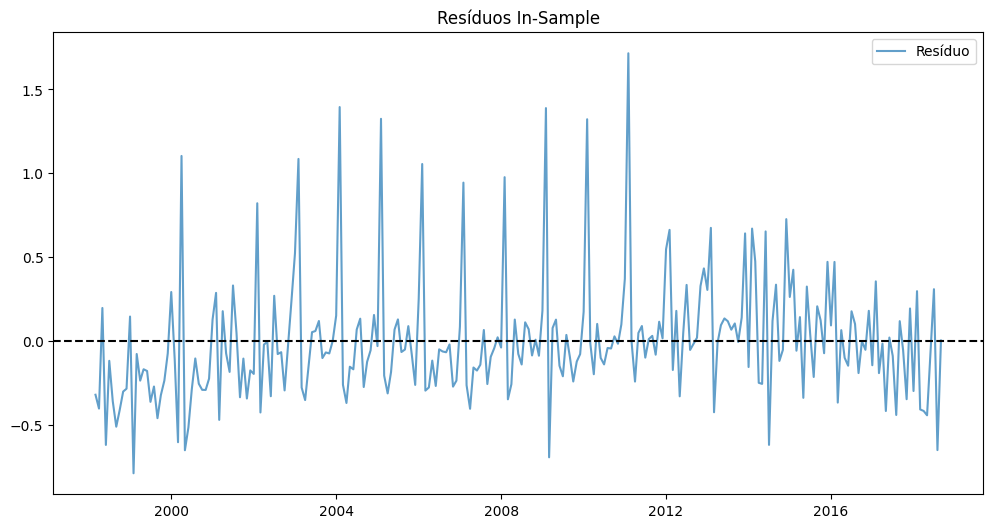

Média: 0.0002, Desvio-padrão: 0.3693

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=8.7355, p-valor=0.5574 → Sem autocorrelação
Lag 20: estatística=133.7899, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

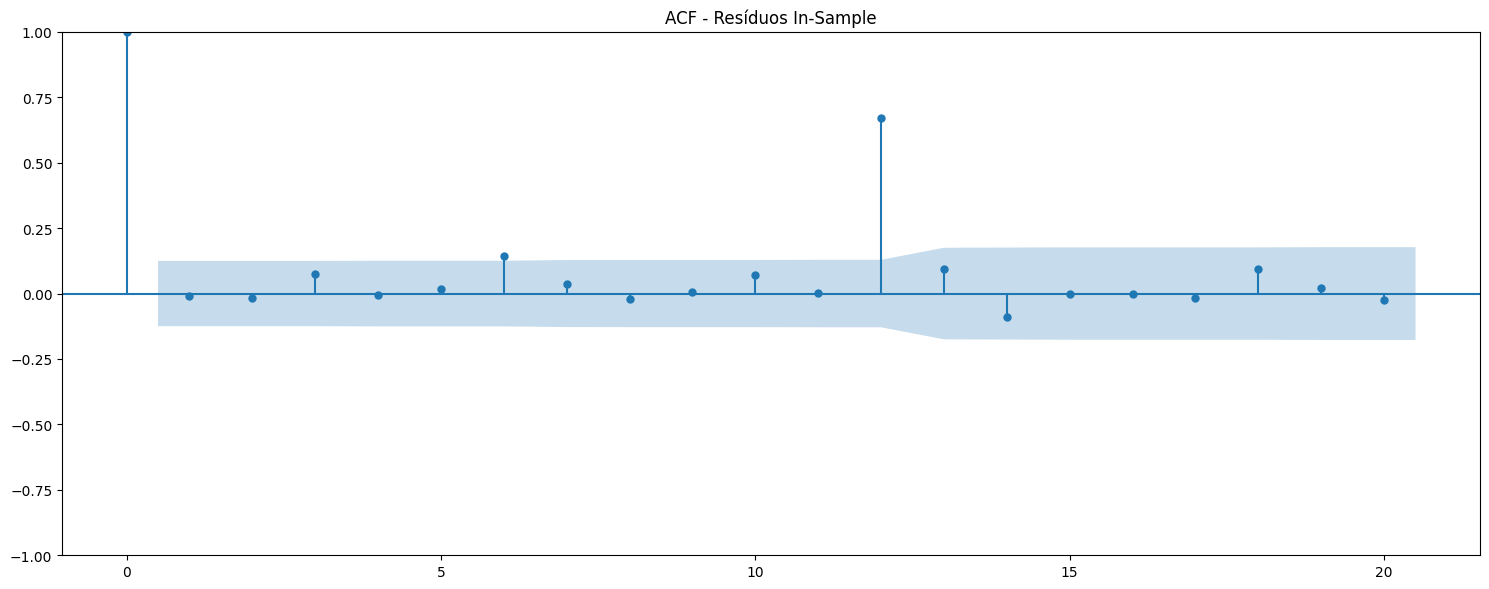


Etapa 4 - Previsões Out-of-Sample


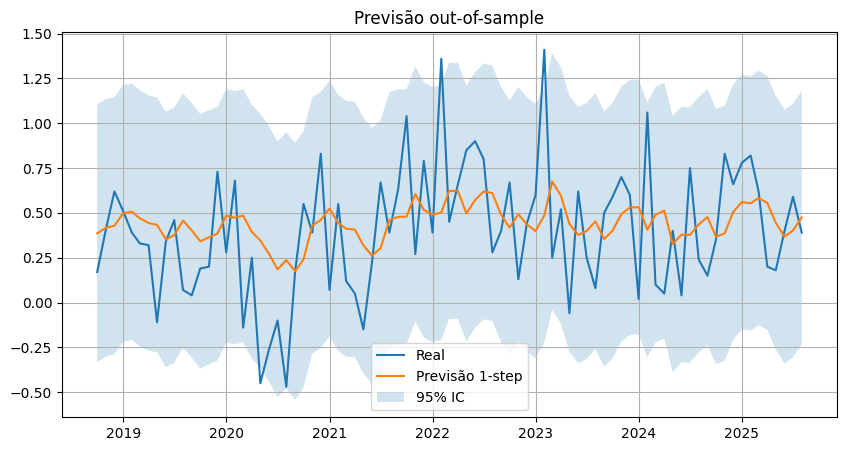


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2712
MAPE: 1.7371
MSE: 0.1142

Etapa 6 - Análise de Resíduos Out-of-Sample


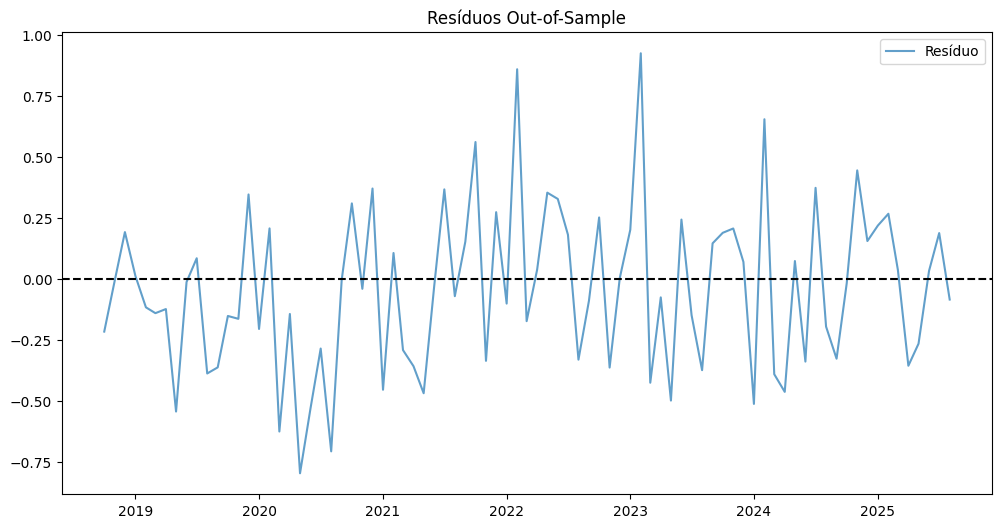

Média: -0.0444, Desvio-padrão: 0.3370

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=15.2741, p-valor=0.1224 → Sem autocorrelação
Lag 20: estatística=40.3253, p-valor=0.0045 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

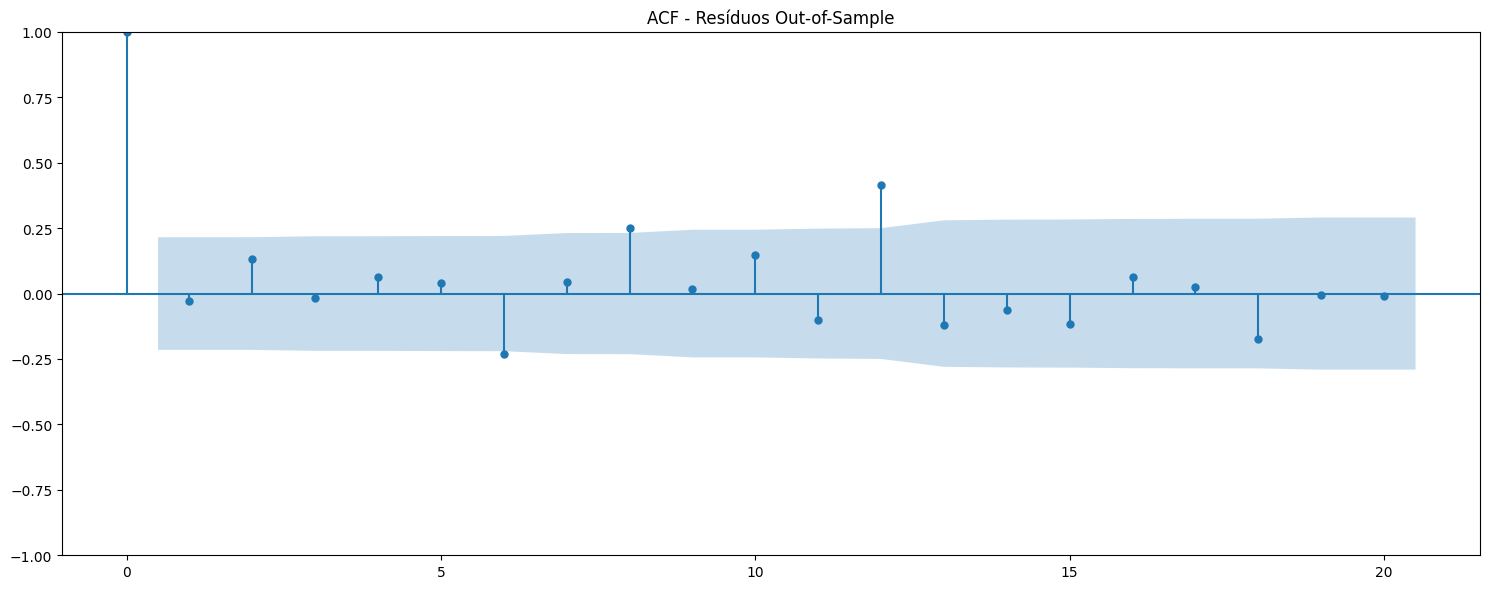


Pipeline finalizado!
Tempo total de execução: 0.05 minutos


In [177]:
resultado_ar_6 = rodar_modelo_arima(y_train, y_test, order=(2,0,0), nome_modelo="AR(2)")

### **5.2.2. Modelo MA**

#### **5.2.2.1. MA(1)**

**acaf** -> 3 lags referente a variável **"q"** que corresponde a parte médias móveis do modelo MA e no modelo ARIMA.

Rodando MA(1) com order=(0, 0, 1) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


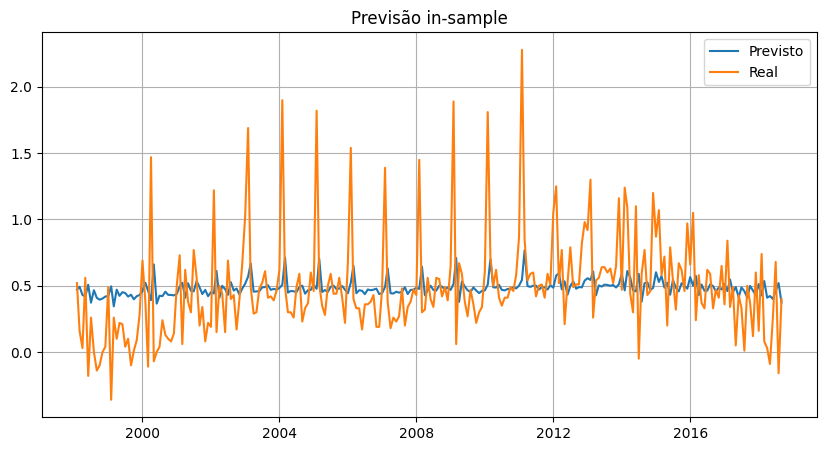


Etapa 3 - Análise de Resíduos In-Sample


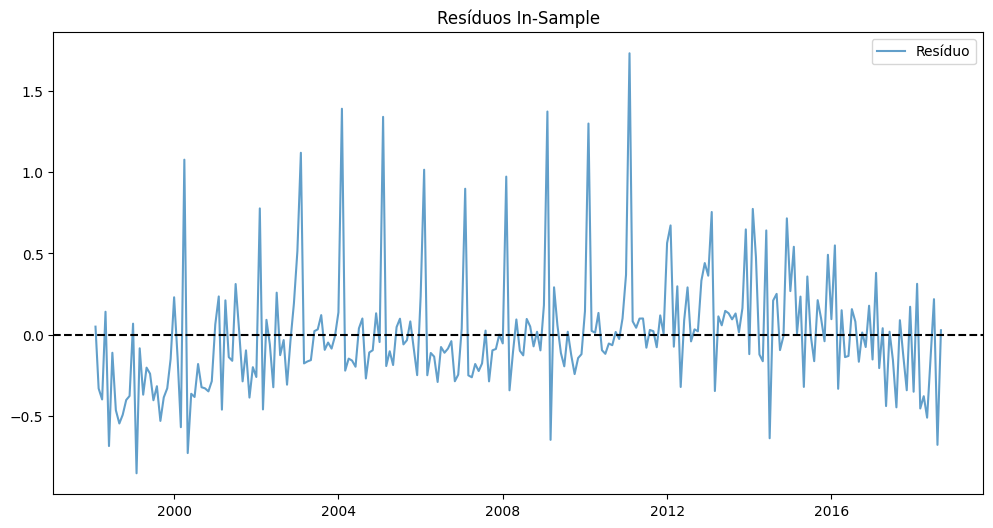

Média: 0.0004, Desvio-padrão: 0.3733

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=24.6100, p-valor=0.0061 → Autocorrelação detectada
Lag 20: estatística=148.3573, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

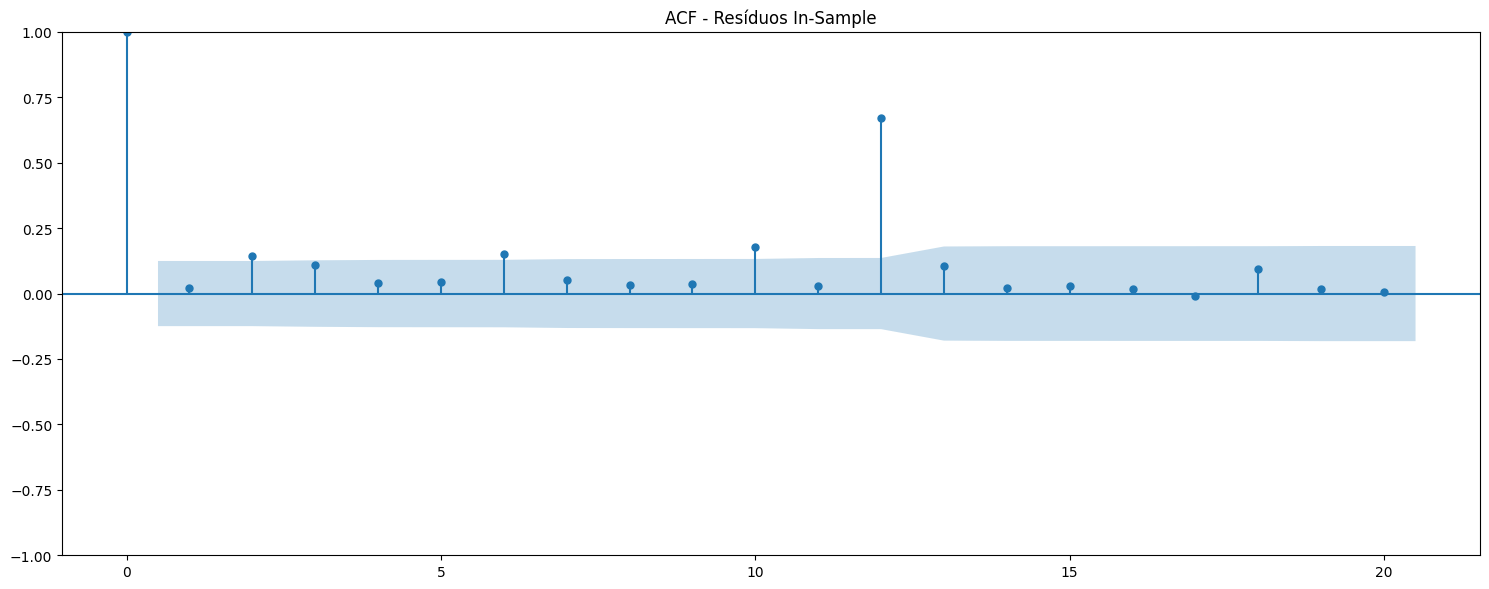


Etapa 4 - Previsões Out-of-Sample


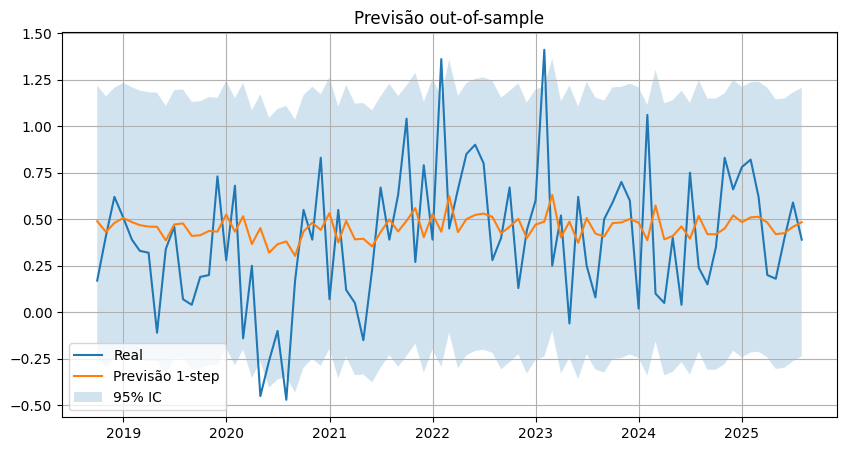


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2863
MAPE: 1.7953
MSE: 0.1261

Etapa 6 - Análise de Resíduos Out-of-Sample


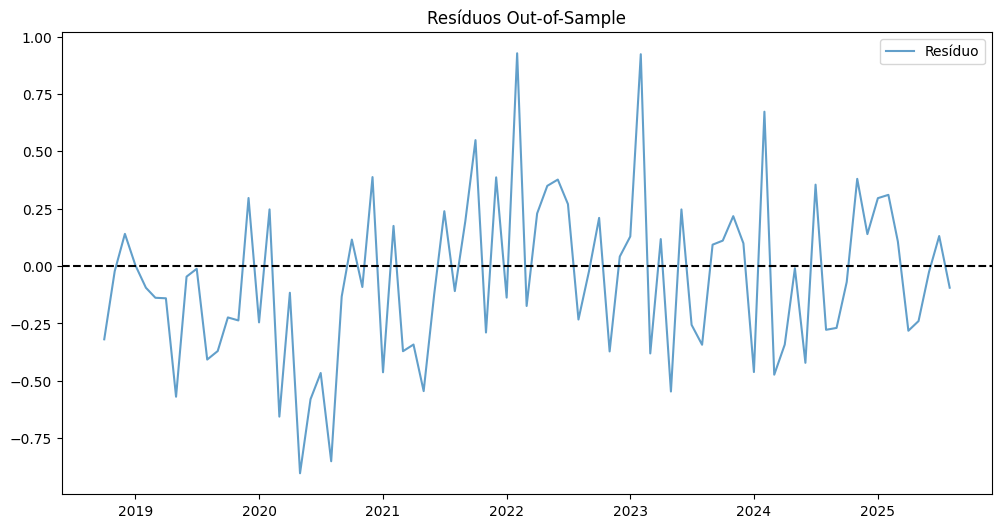

Média: -0.0581, Desvio-padrão: 0.3525

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=23.5953, p-valor=0.0088 → Autocorrelação detectada
Lag 20: estatística=47.9694, p-valor=0.0004 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

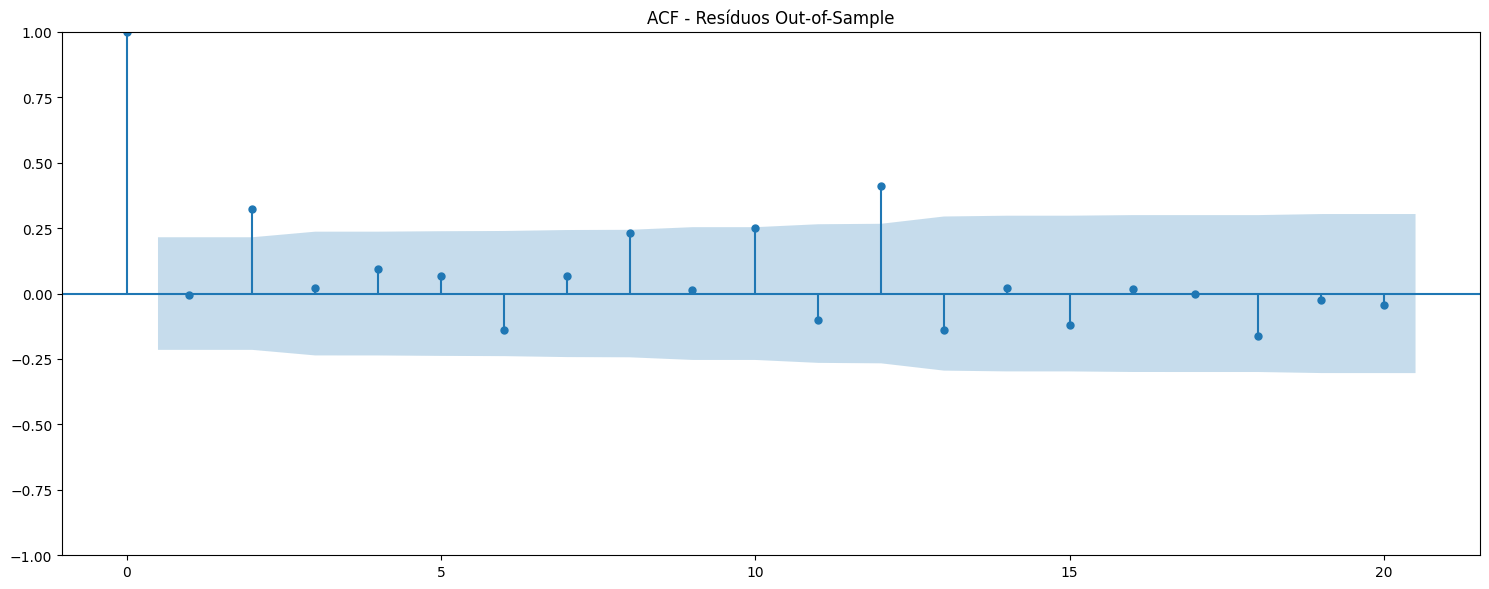


Pipeline finalizado!
Tempo total de execução: 0.04 minutos


In [178]:
resultado_ma_1 = rodar_modelo_arima(y_train, y_test, order=(0,0,1), nome_modelo="MA(1)")

#### **5.2.2.2. MA(2)**

Rodando MA(2) com order=(0, 0, 2) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


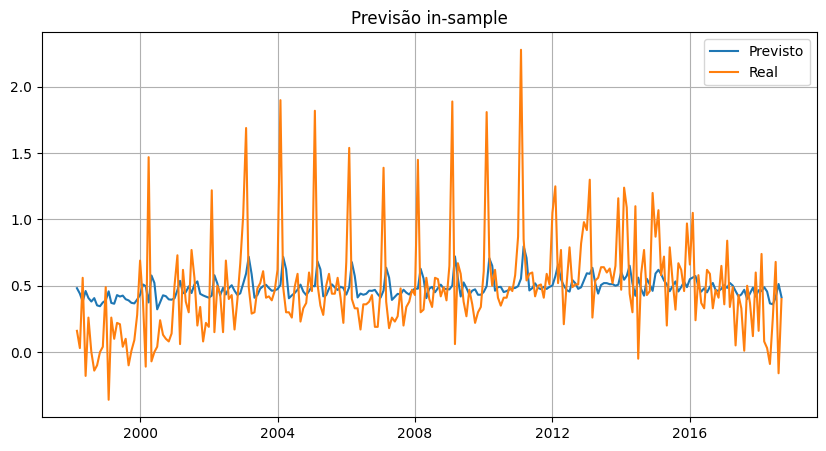


Etapa 3 - Análise de Resíduos In-Sample


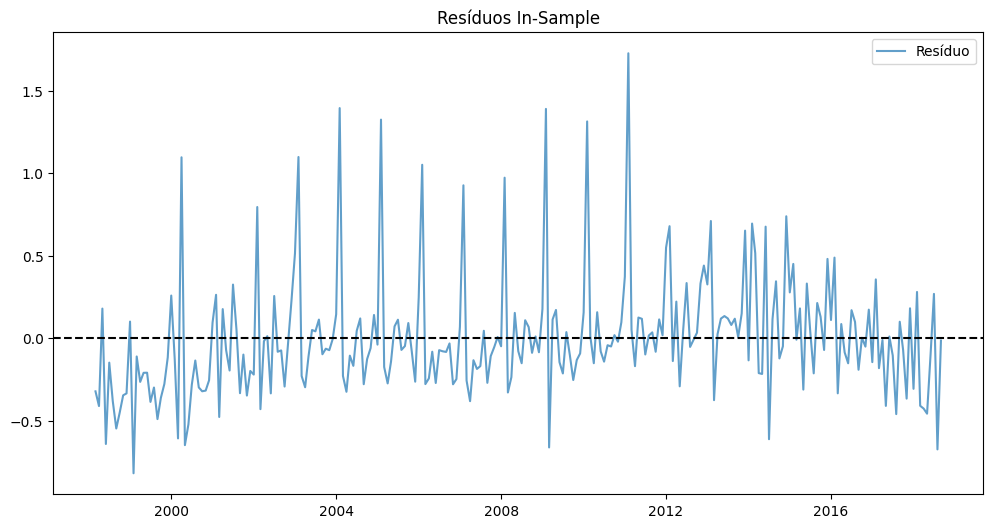

Média: 0.0002, Desvio-padrão: 0.3711

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=14.1091, p-valor=0.1681 → Sem autocorrelação
Lag 20: estatística=138.4962, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

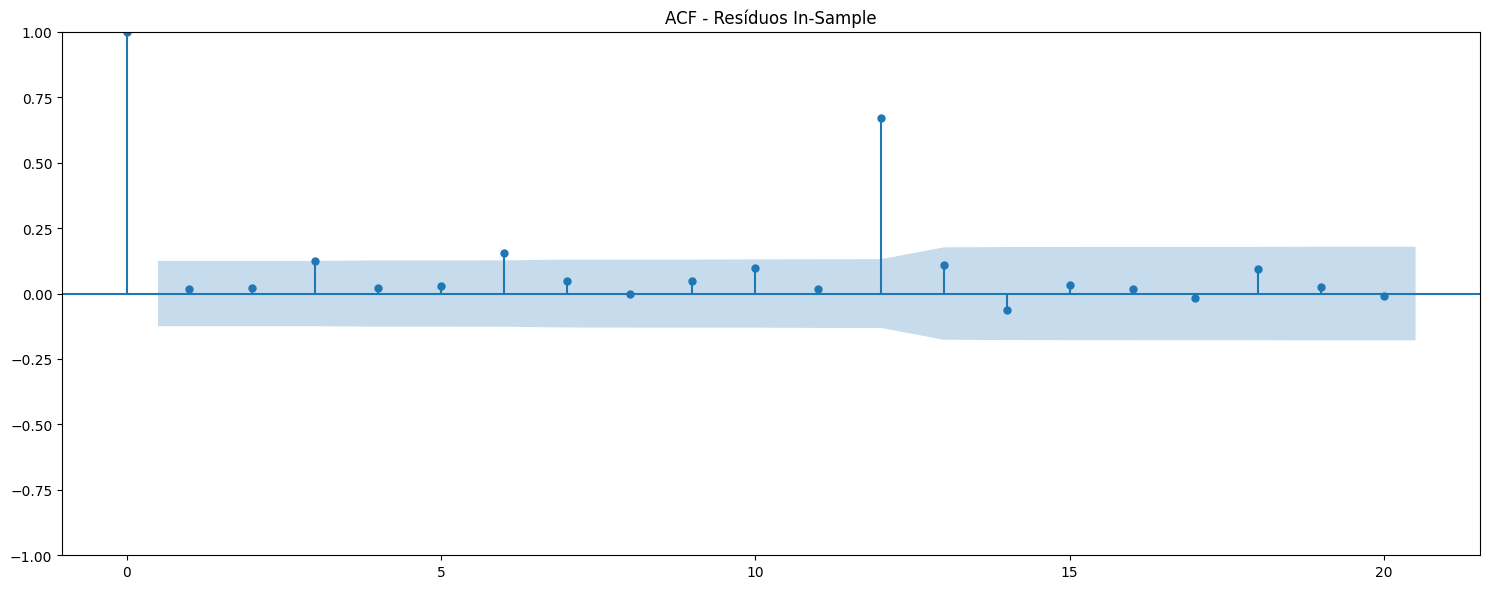


Etapa 4 - Previsões Out-of-Sample


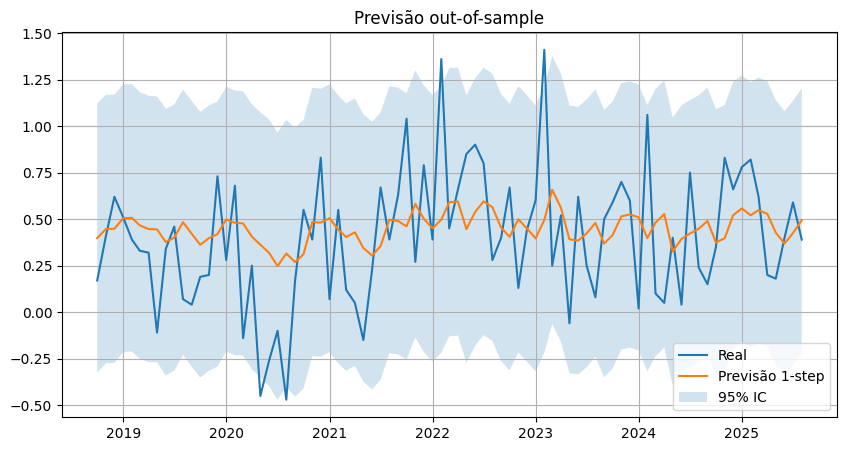


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2748
MAPE: 1.7602
MSE: 0.1164

Etapa 6 - Análise de Resíduos Out-of-Sample


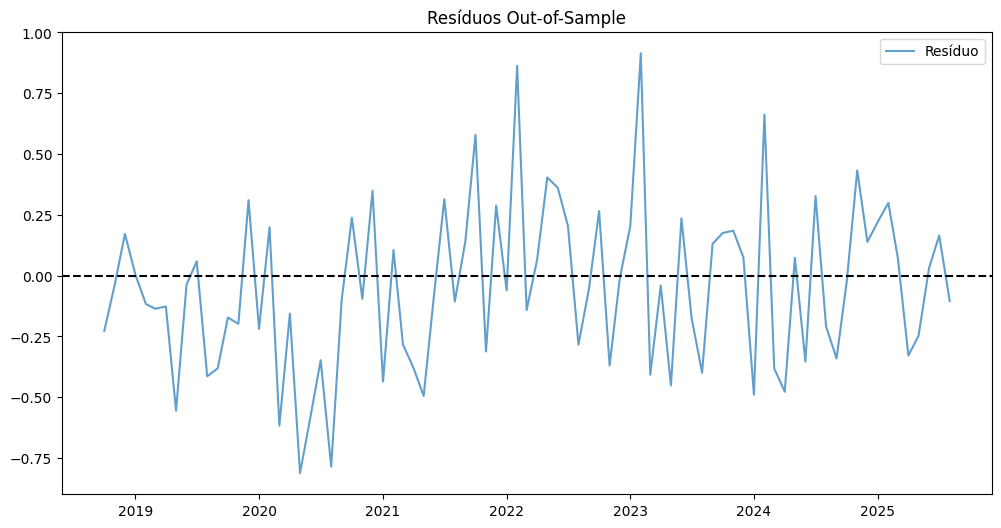

Média: -0.0515, Desvio-padrão: 0.3393

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=16.4699, p-valor=0.0869 → Sem autocorrelação
Lag 20: estatística=40.2776, p-valor=0.0046 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

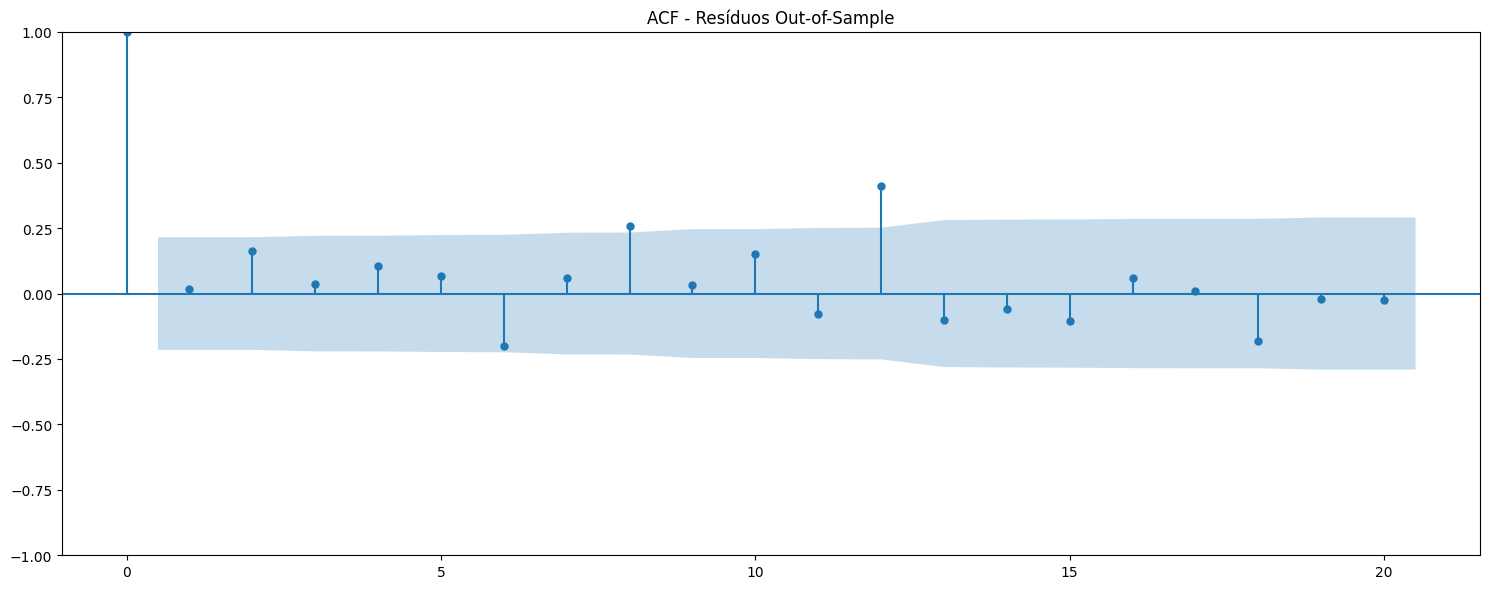


Pipeline finalizado!
Tempo total de execução: 0.05 minutos


In [179]:
resultado_ma_2 = rodar_modelo_arima(y_train, y_test, order=(0,0,2), nome_modelo="MA(2)")

#### **5.2.2.3. MA(3)**

Rodando MA(3) com order=(0, 0, 3) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


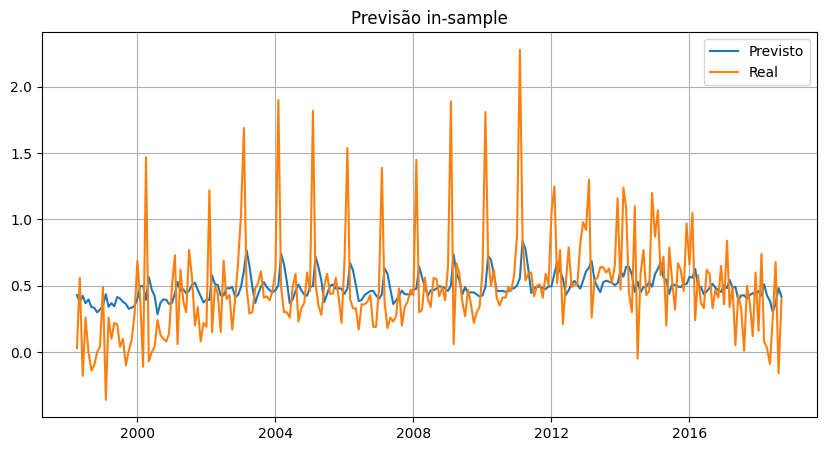


Etapa 3 - Análise de Resíduos In-Sample


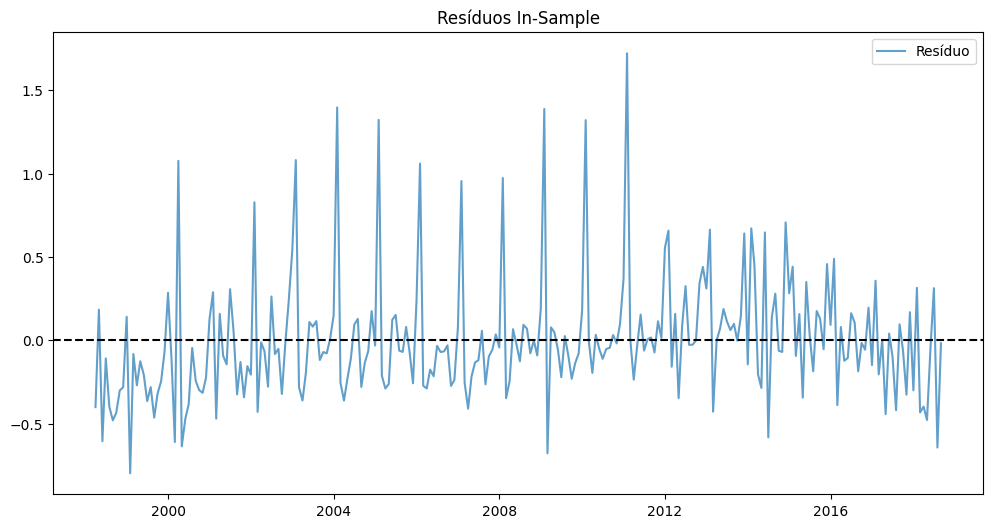

Média: 0.0015, Desvio-padrão: 0.3688

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=8.0902, p-valor=0.6200 → Sem autocorrelação
Lag 20: estatística=134.9790, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

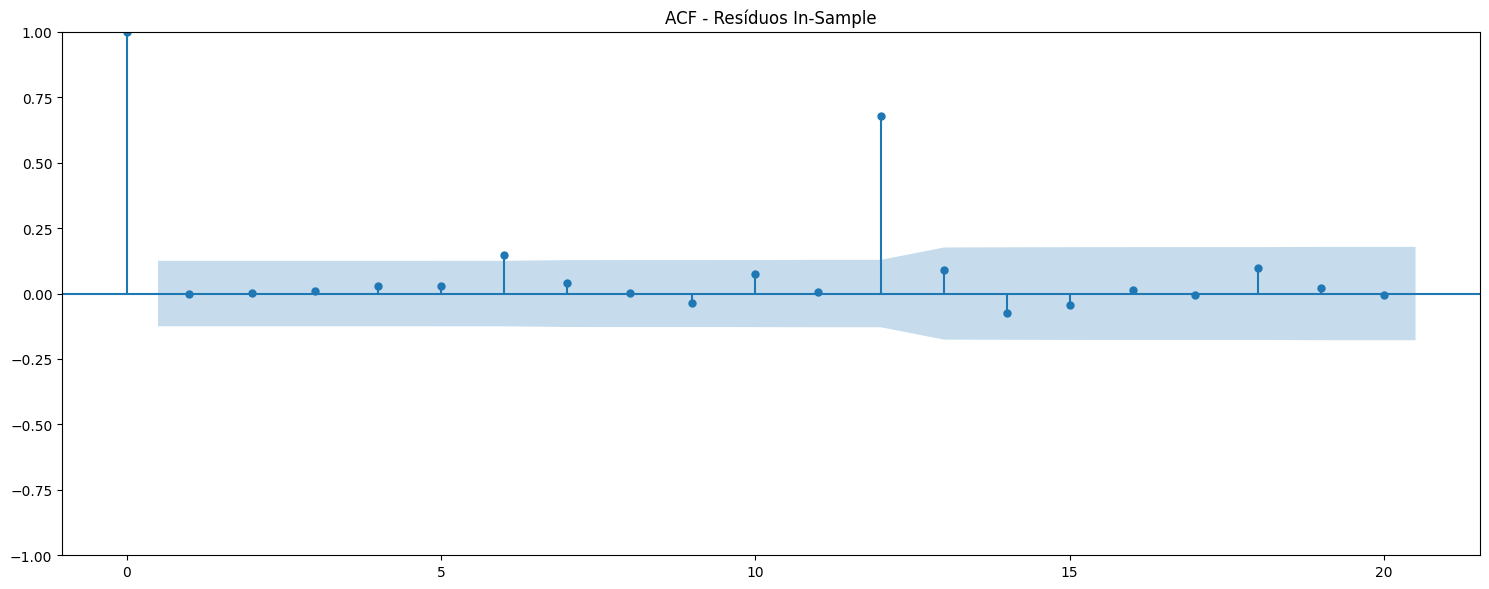


Etapa 4 - Previsões Out-of-Sample


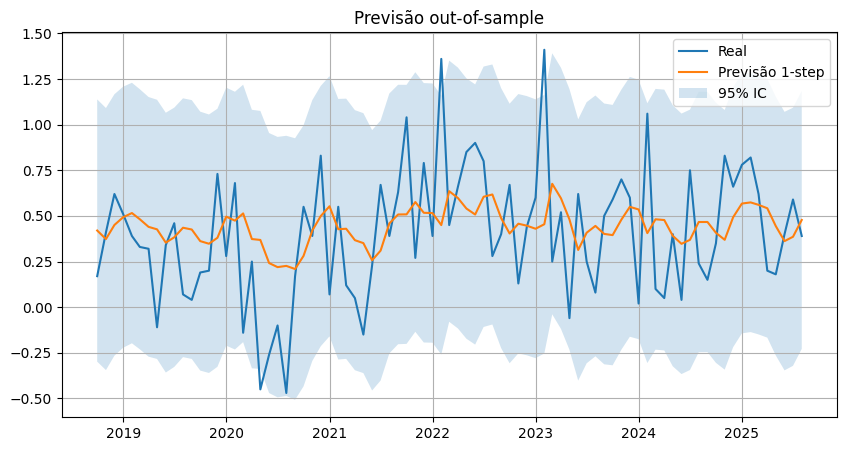


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2731
MAPE: 1.7371
MSE: 0.1164

Etapa 6 - Análise de Resíduos Out-of-Sample


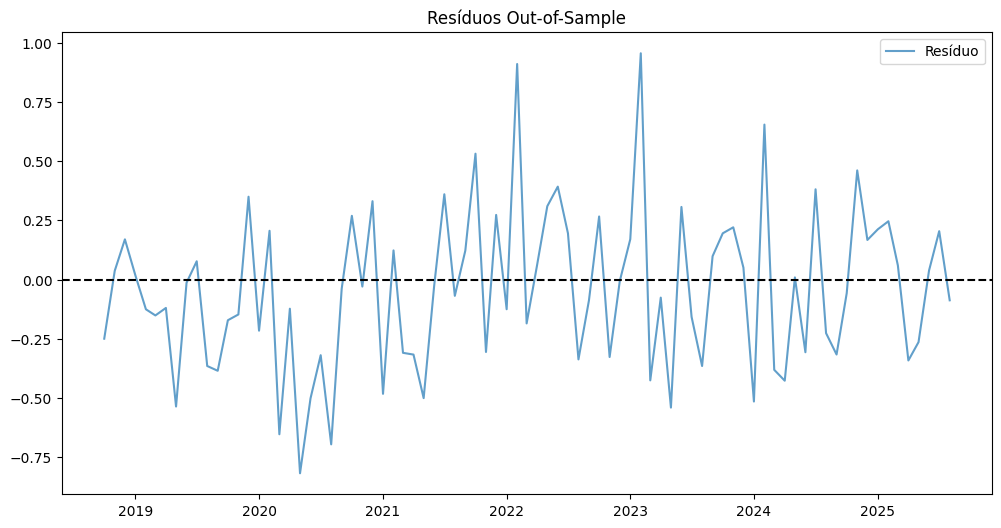

Média: -0.0459, Desvio-padrão: 0.3402

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=16.7131, p-valor=0.0810 → Sem autocorrelação
Lag 20: estatística=43.6503, p-valor=0.0017 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

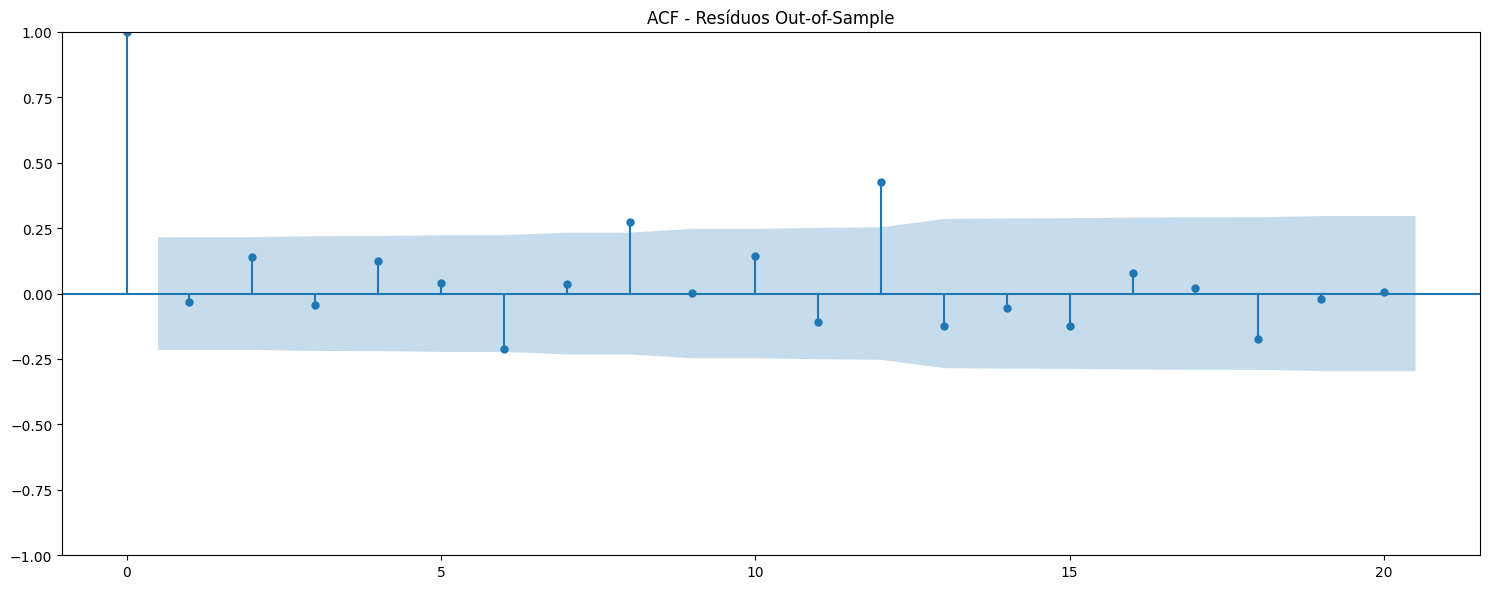


Pipeline finalizado!
Tempo total de execução: 0.06 minutos


In [180]:
resultado_ma_3 = rodar_modelo_arima(y_train, y_test, order=(0,0,3), nome_modelo="MA(3)")

### **5.2.3. Modelo ARMA**



#### **5.2.3.1. ARMA(1,1)**

Rodando ARMA(2,3) com order=(2, 0, 3) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


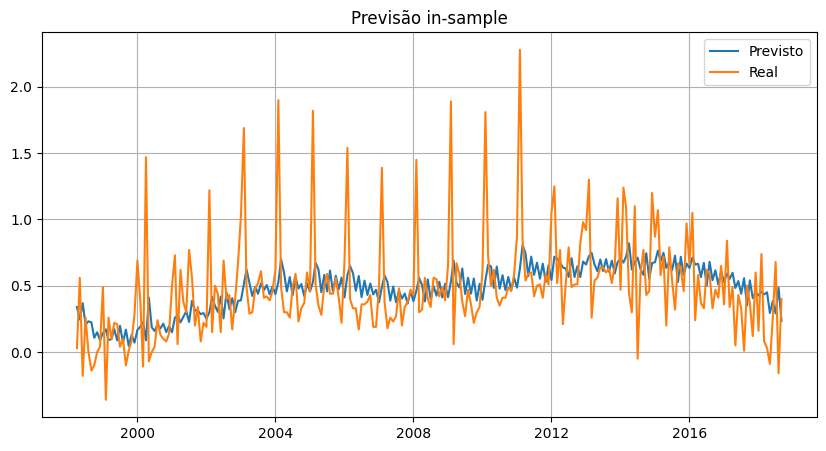


Etapa 3 - Análise de Resíduos In-Sample


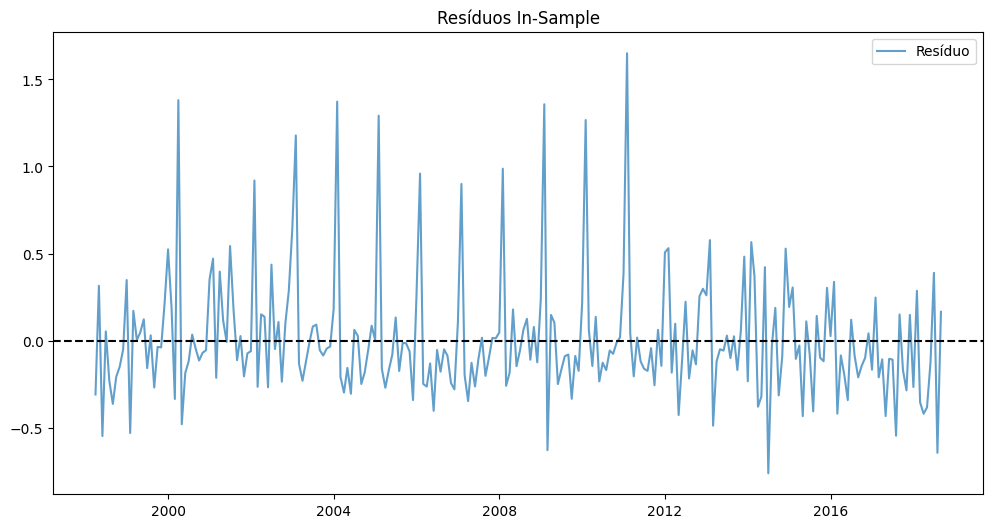

Média: 0.0078, Desvio-padrão: 0.3551

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=13.8409, p-valor=0.1804 → Sem autocorrelação
Lag 20: estatística=140.9330, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

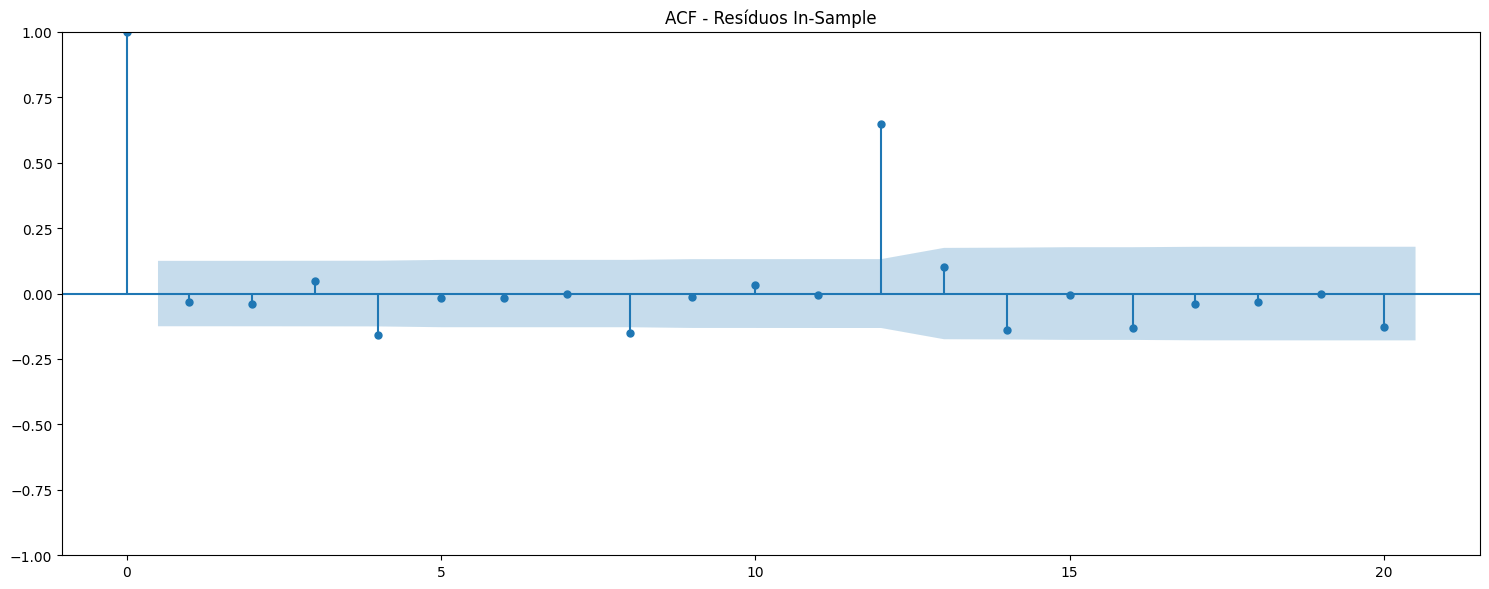


Etapa 4 - Previsões Out-of-Sample


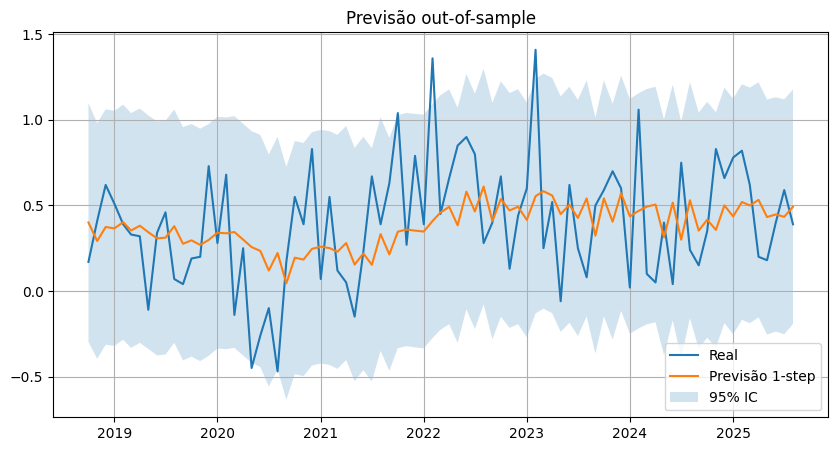


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2698
MAPE: 1.5351
MSE: 0.1152

Etapa 6 - Análise de Resíduos Out-of-Sample


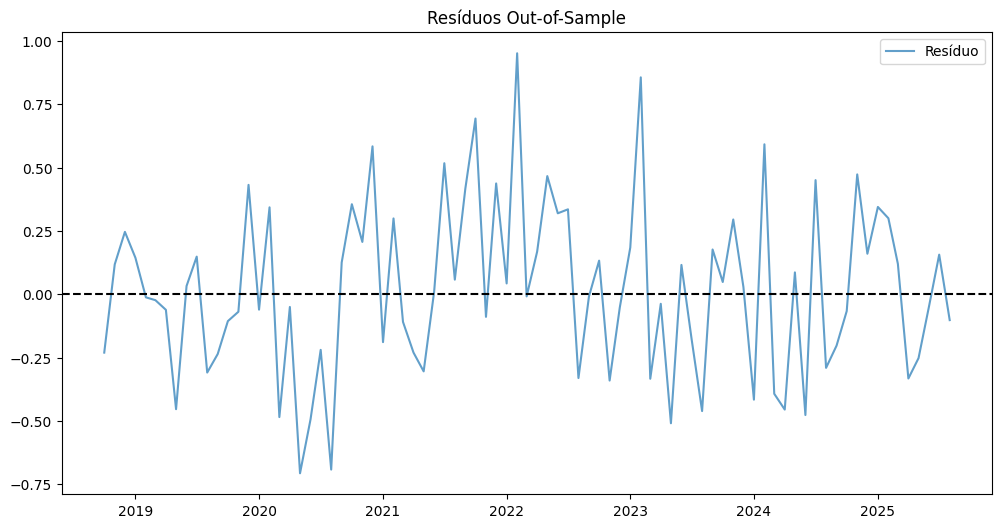

Média: 0.0185, Desvio-padrão: 0.3410

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=18.3665, p-valor=0.0491 → Autocorrelação detectada
Lag 20: estatística=44.2542, p-valor=0.0014 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

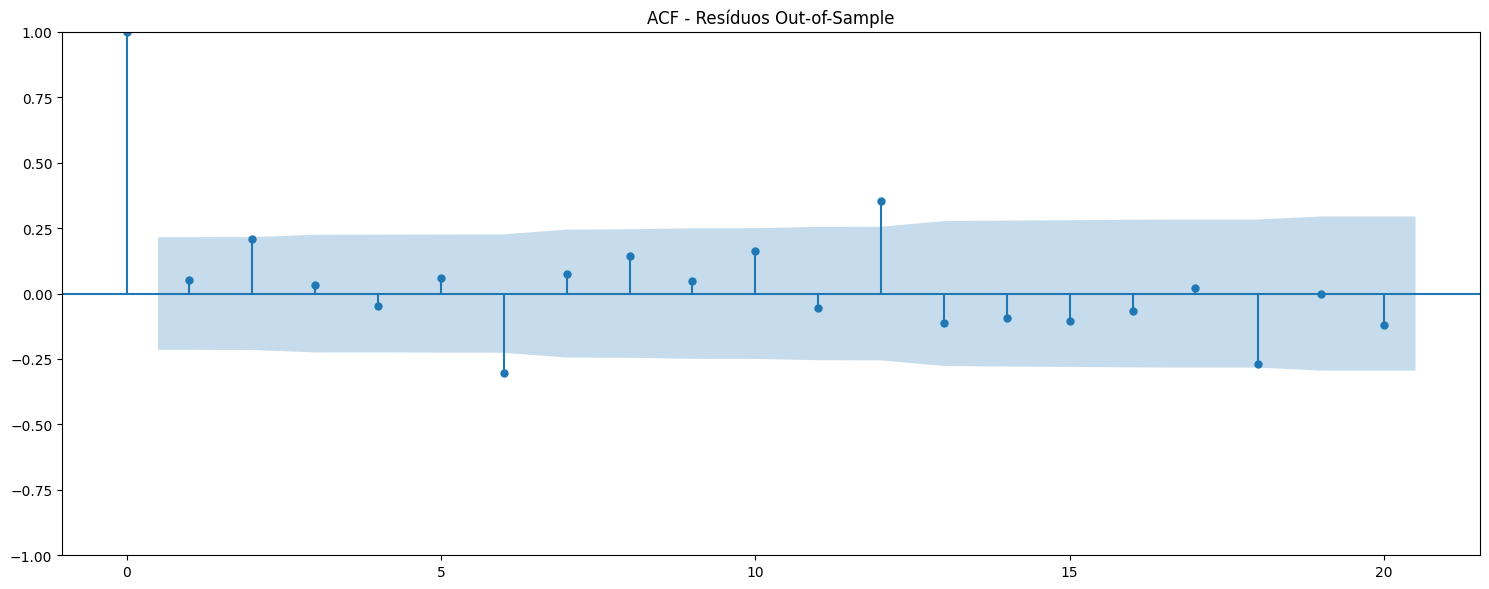


Pipeline finalizado!
Tempo total de execução: 0.08 minutos


In [ ]:
resultado_arma_1_1 = rodar_modelo_arima(y_train, y_test, order=(1,0,1), nome_modelo="ARMA(1,1)")

#### **5.2.3.1. ARMA(2,1)**

Rodando ARMA(2,3) com order=(2, 0, 3) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


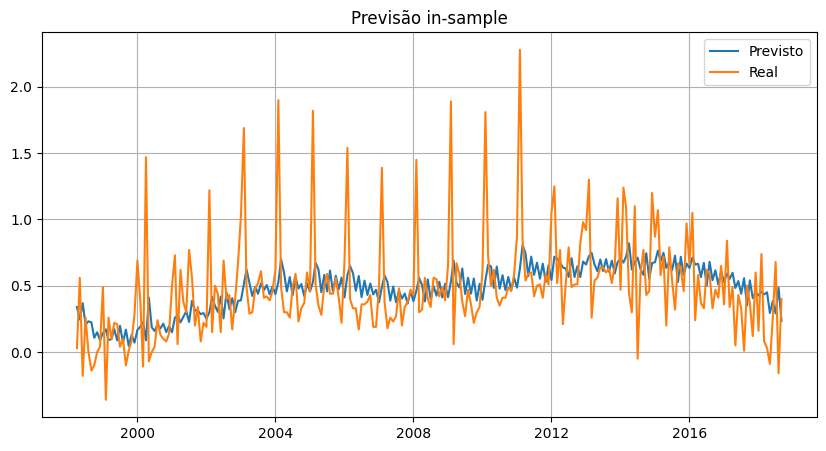


Etapa 3 - Análise de Resíduos In-Sample


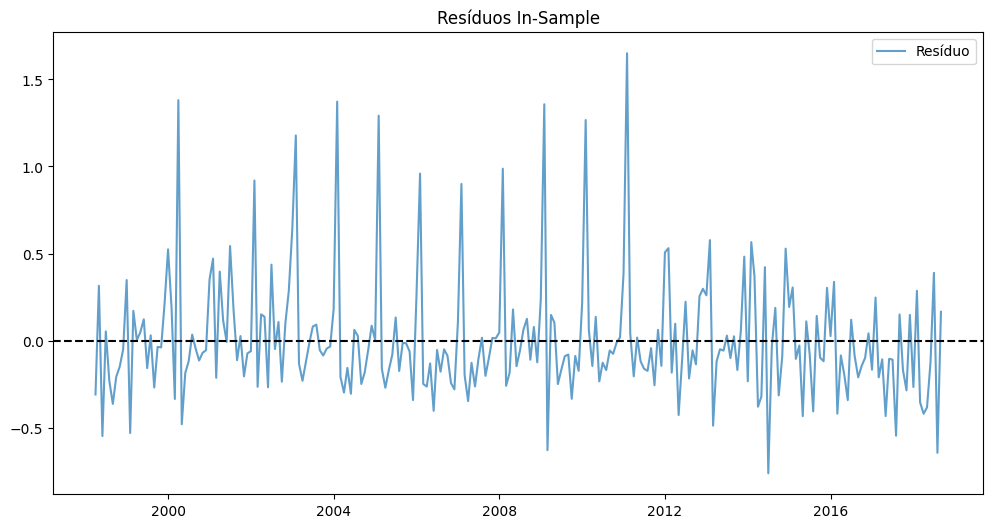

Média: 0.0078, Desvio-padrão: 0.3551

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=13.8409, p-valor=0.1804 → Sem autocorrelação
Lag 20: estatística=140.9330, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

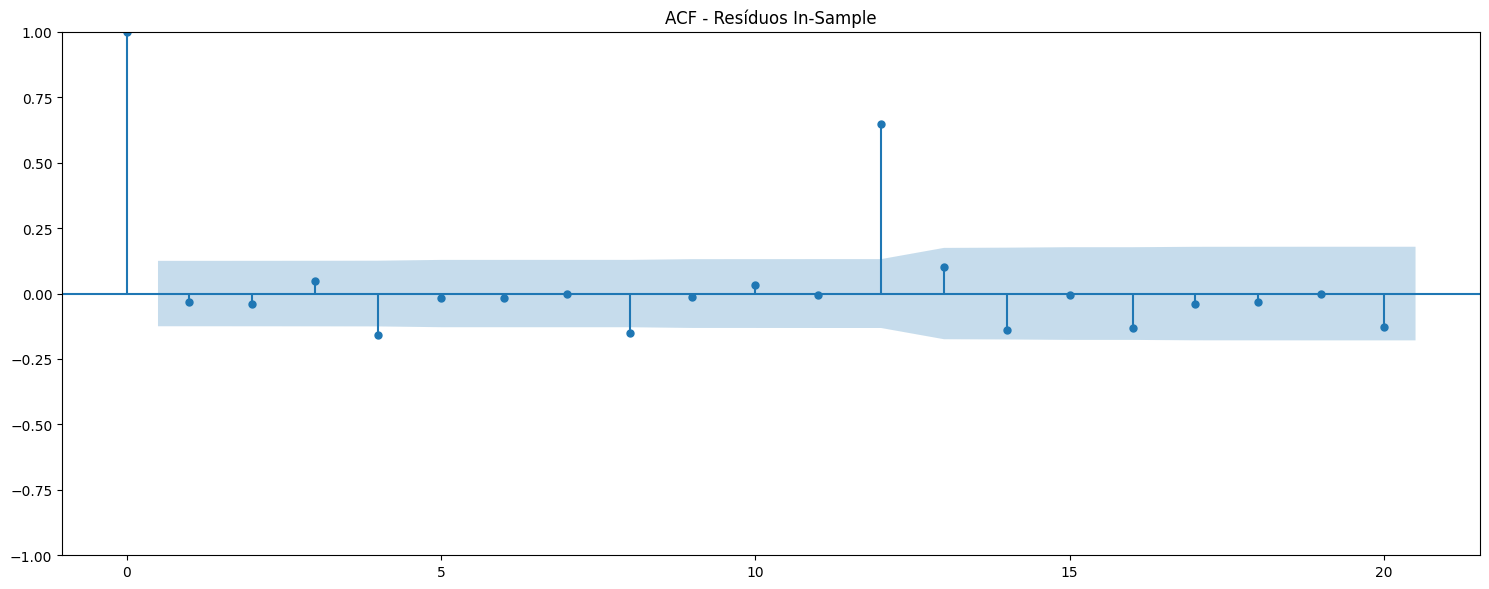


Etapa 4 - Previsões Out-of-Sample


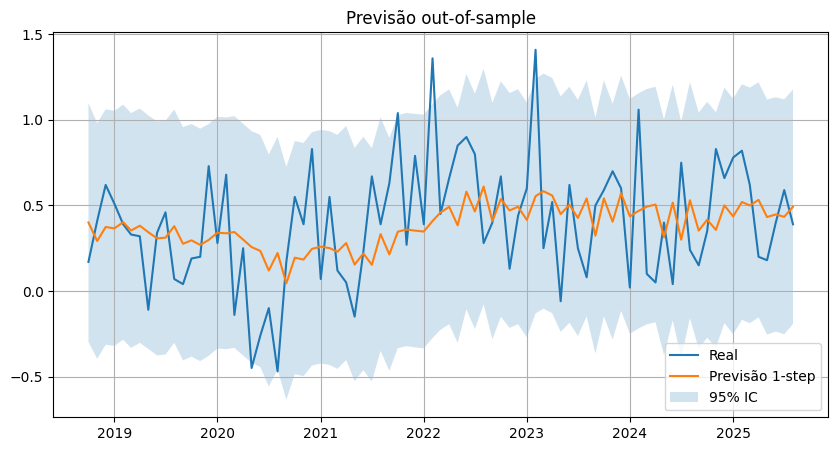


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2698
MAPE: 1.5351
MSE: 0.1152

Etapa 6 - Análise de Resíduos Out-of-Sample


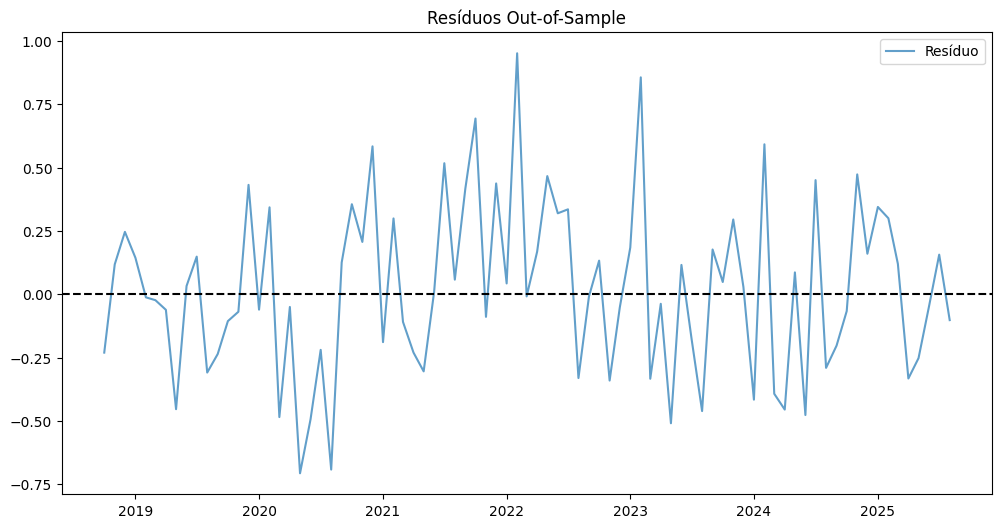

Média: 0.0185, Desvio-padrão: 0.3410

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=18.3665, p-valor=0.0491 → Autocorrelação detectada
Lag 20: estatística=44.2542, p-valor=0.0014 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

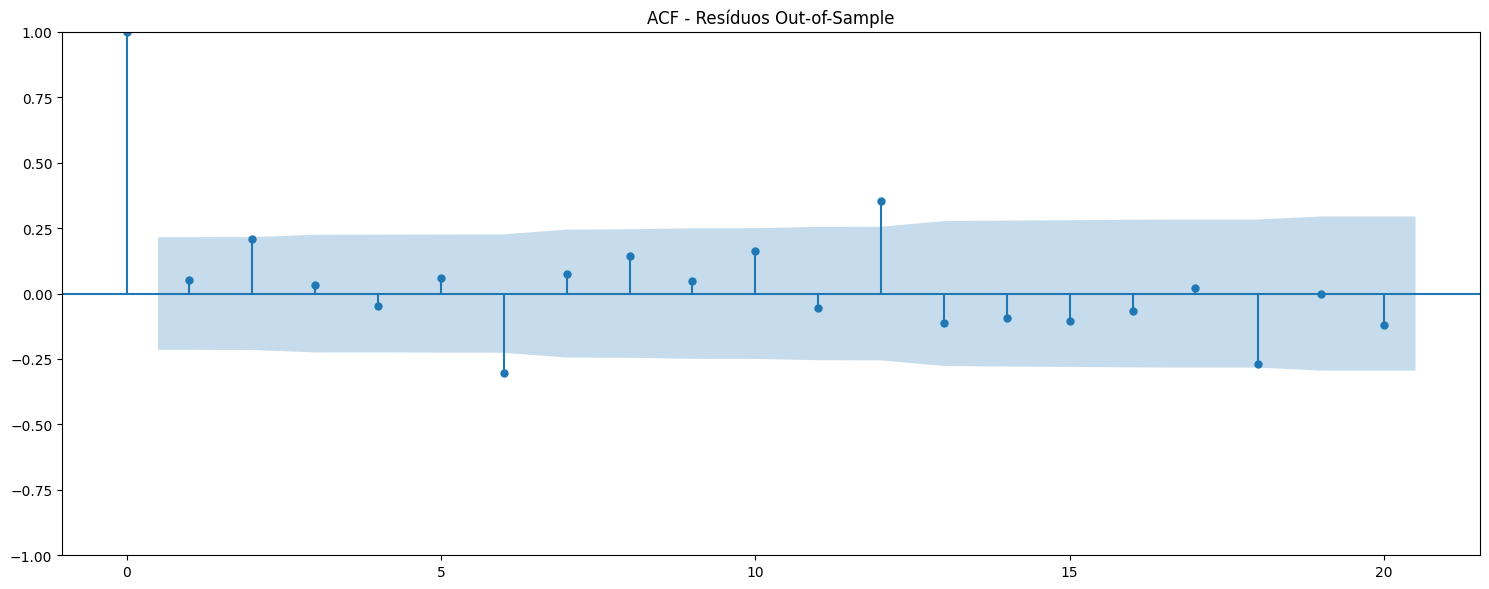


Pipeline finalizado!
Tempo total de execução: 0.08 minutos


In [ ]:
resultado_arma_2_1 = rodar_modelo_arima(y_train, y_test, order=(2,0,1), nome_modelo="ARMA(2,1)")

#### **5.2.3.1. ARMA(1,2)**

In [ ]:
resultado_arma_1_2 = rodar_modelo_arima(y_train, y_test, order=(1,0,2), nome_modelo="ARMA(1,2)")


#### **5.2.3.1. ARMA(1,3)**

In [ ]:
resultado_arma_1_3 = rodar_modelo_arima(y_train, y_test, order=(1,0,3), nome_modelo="ARMA(2,2)")


#### **5.2.3.1. ARMA(2,2)**

In [ ]:
resultado_arma_2_2 = rodar_modelo_arima(y_train, y_test, order=(2,0,2), nome_modelo="ARMA(2,2)")


#### **5.2.3.1. ARMA(2,3)**

Rodando ARMA(2,3) com order=(2, 0, 3) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


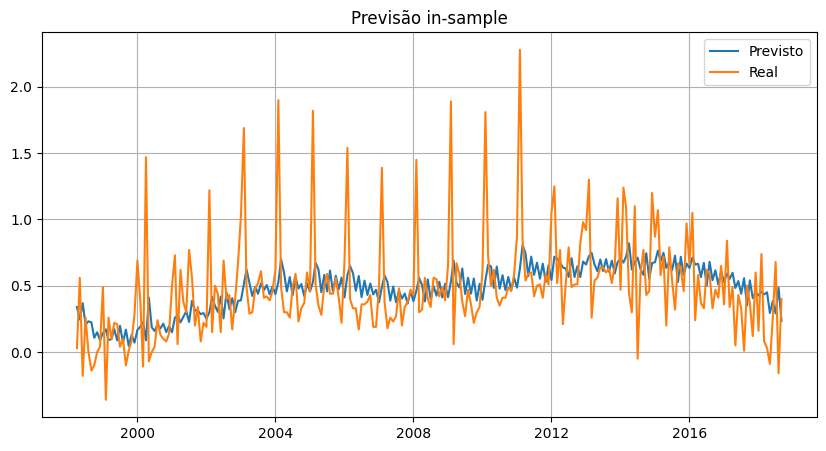


Etapa 3 - Análise de Resíduos In-Sample


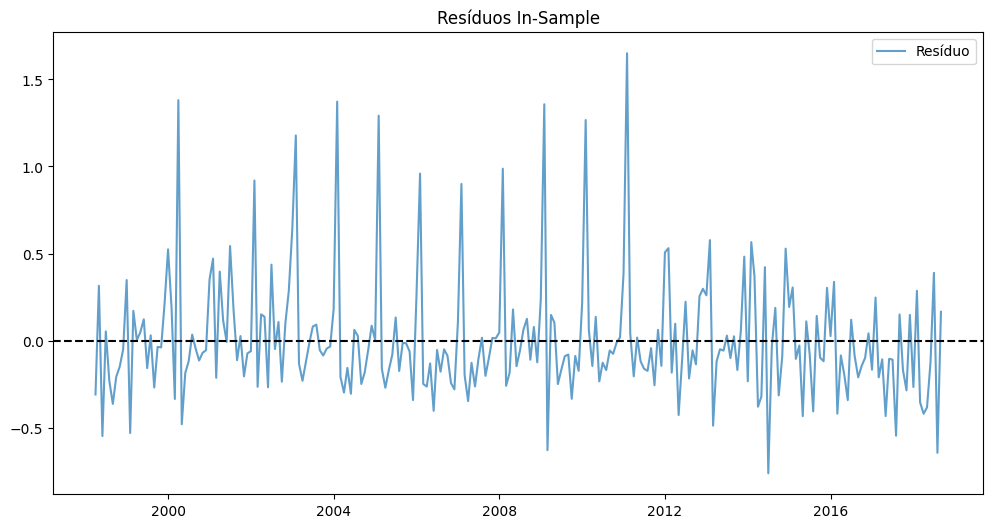

Média: 0.0078, Desvio-padrão: 0.3551

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=13.8409, p-valor=0.1804 → Sem autocorrelação
Lag 20: estatística=140.9330, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

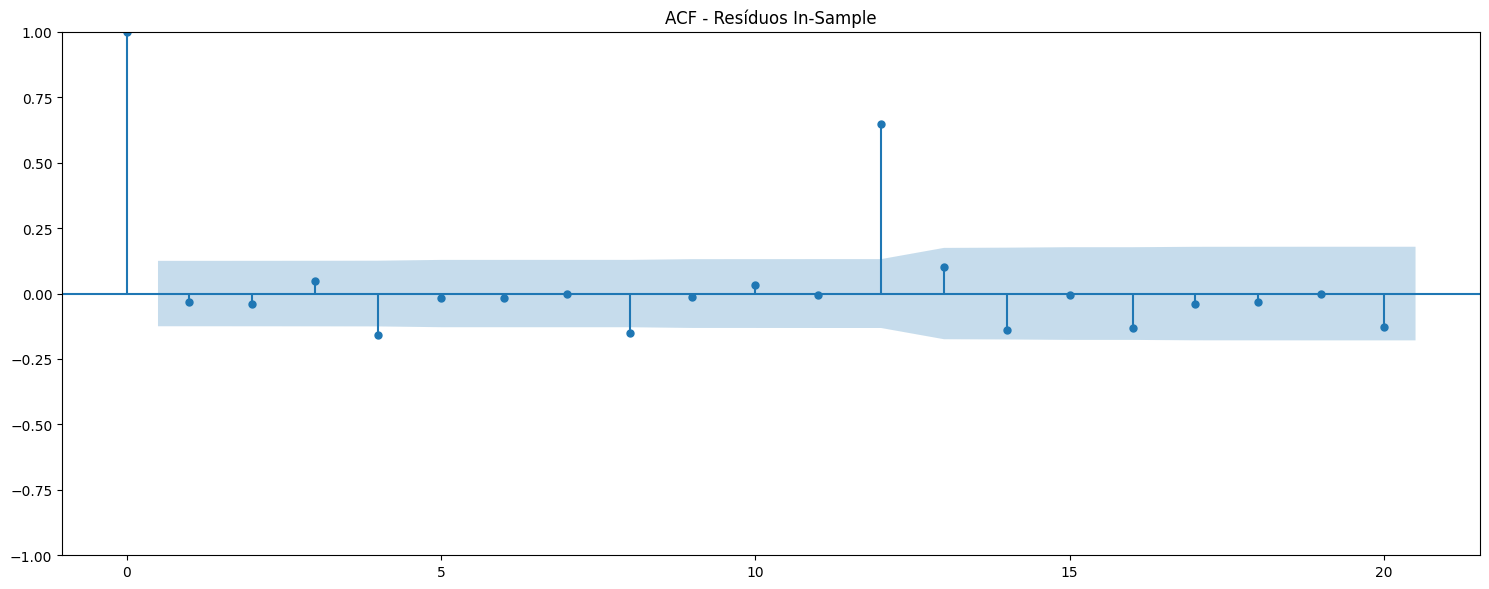


Etapa 4 - Previsões Out-of-Sample


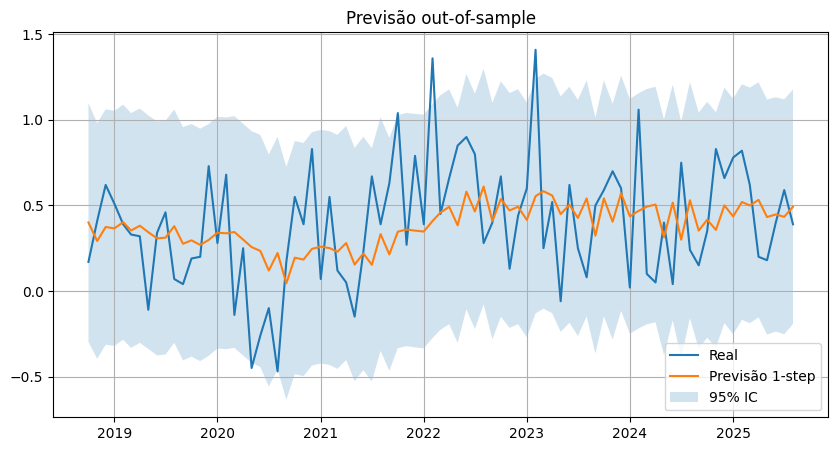


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2698
MAPE: 1.5351
MSE: 0.1152

Etapa 6 - Análise de Resíduos Out-of-Sample


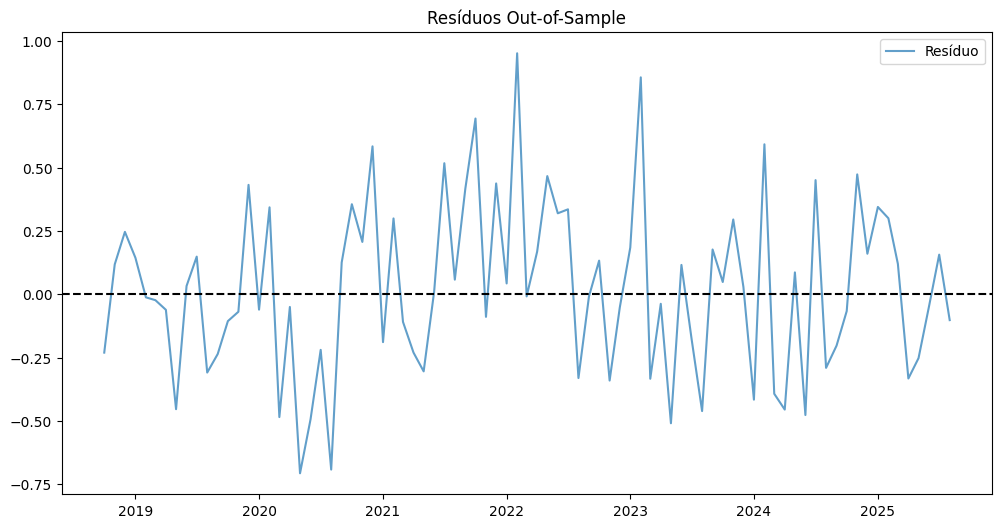

Média: 0.0185, Desvio-padrão: 0.3410

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=18.3665, p-valor=0.0491 → Autocorrelação detectada
Lag 20: estatística=44.2542, p-valor=0.0014 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

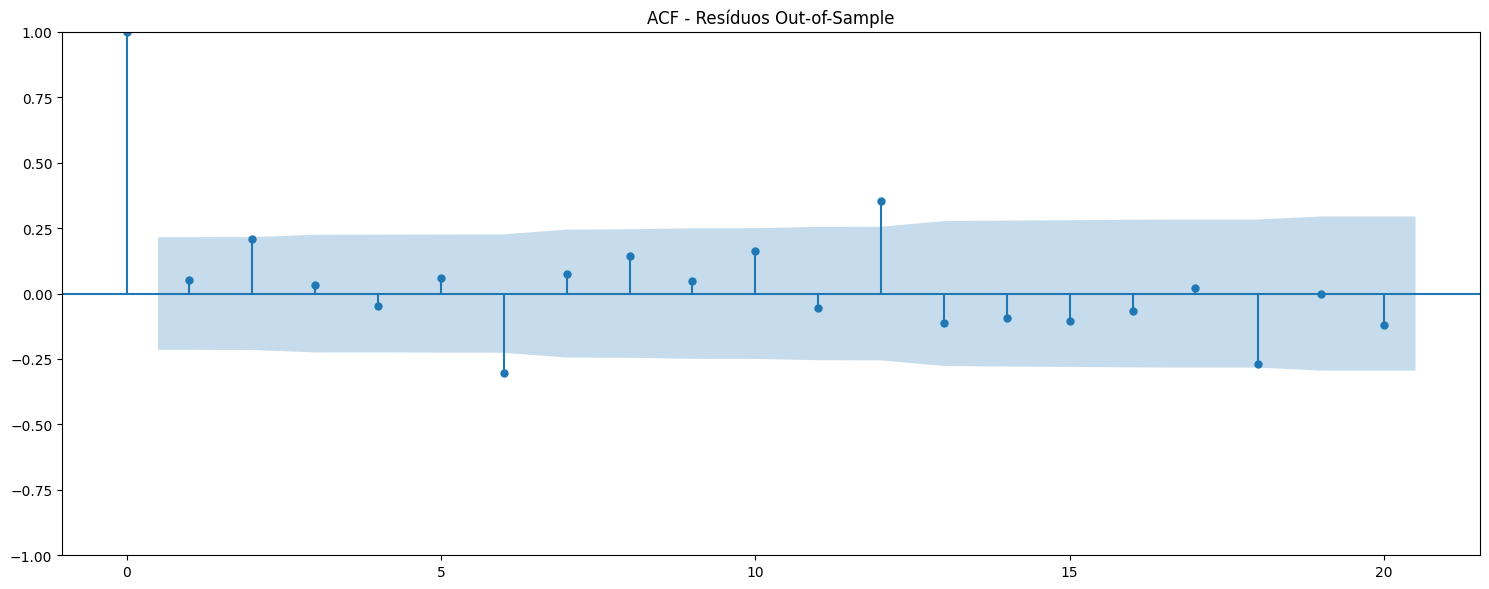


Pipeline finalizado!
Tempo total de execução: 0.08 minutos


In [ ]:
resultado_arma_2_3 = rodar_modelo_arima(y_train, y_test, order=(2,0,3), nome_modelo="ARMA(2,3)")

### **5.2.4. Modelo ARIMA**

<span style="color:red;">**TODO**</span>: com a séria já é escionário e não precisa da diferenciação assume 0 no "I" do modelo ARIMA!


#### **5.2.4.1. ARIMA(2,0,2)**

Rodando ARIMA(2,1,2) com order=(2, 0, 2) seasonal_order=(0, 0, 0, 0)

Etapa 1 - Treinamento do Modelo

Etapa 2 - Previsões In-Sample


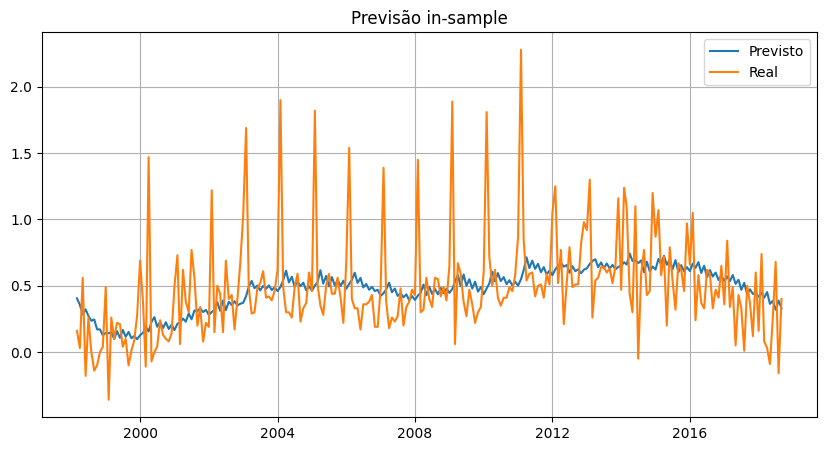


Etapa 3 - Análise de Resíduos In-Sample


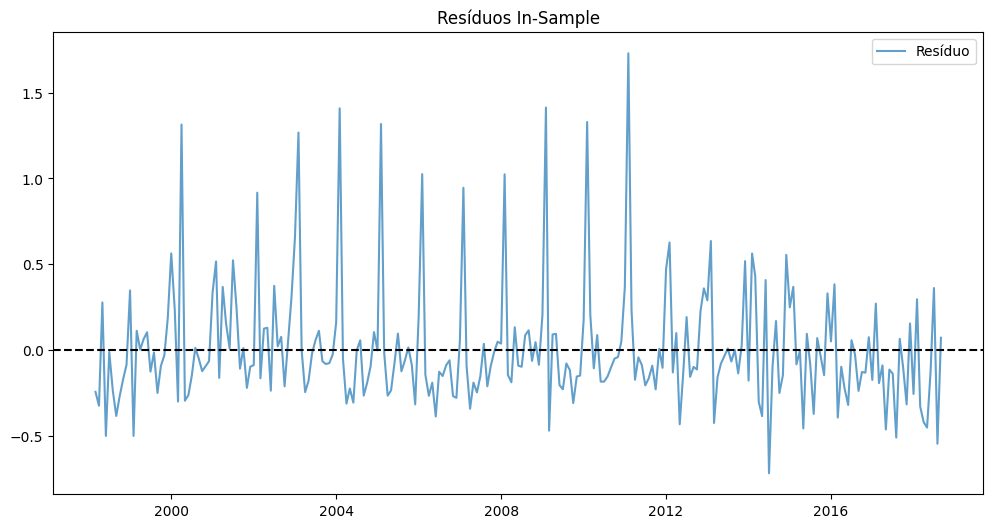

Média: 0.0113, Desvio-padrão: 0.3578

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=14.4034, p-valor=0.1554 → Sem autocorrelação
Lag 20: estatística=153.9779, p-valor=0.0000 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

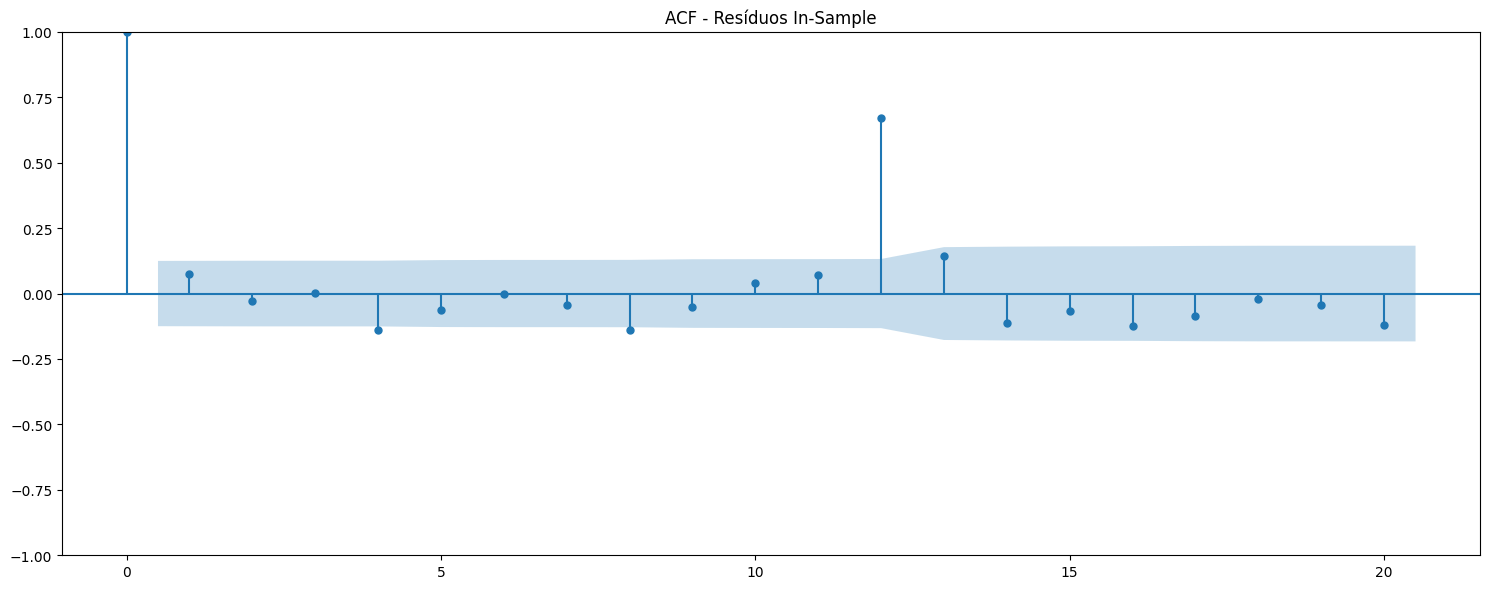


Etapa 4 - Previsões Out-of-Sample


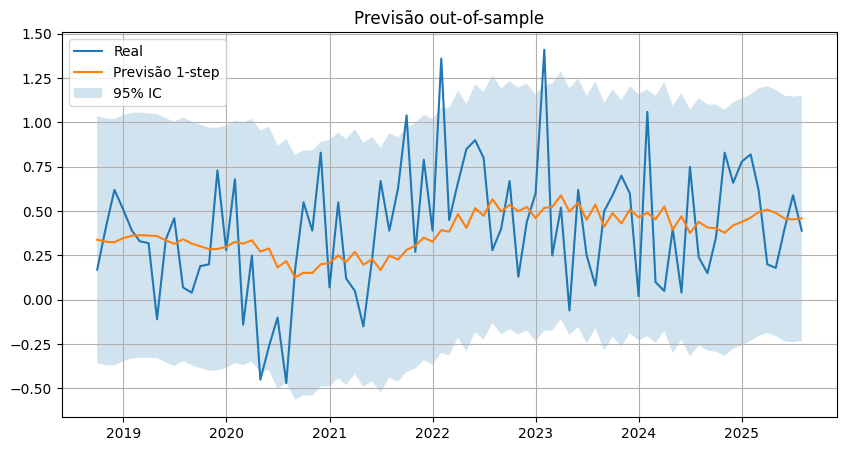


Etapa 5 - Avaliação de Métricas
Avaliação Out-of-Sample
MAE: 0.2728
MAPE: 1.5520
MSE: 0.1189

Etapa 6 - Análise de Resíduos Out-of-Sample


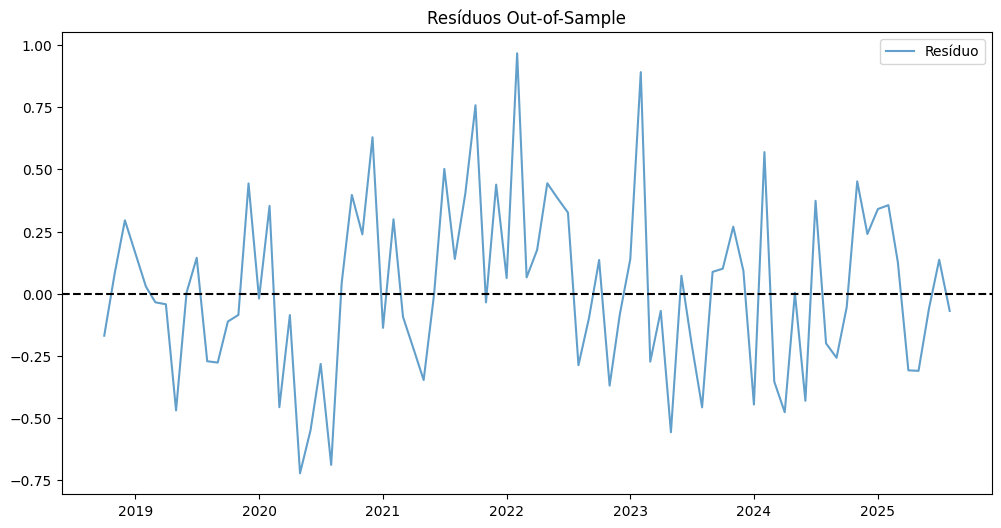

Média: 0.0207, Desvio-padrão: 0.3463

Teste Ljung-Box (autocorrelação):
Lag 10: estatística=19.4452, p-valor=0.0350 → Autocorrelação detectada
Lag 20: estatística=44.1610, p-valor=0.0014 → Autocorrelação detectada


<Figure size 1000x400 with 0 Axes>

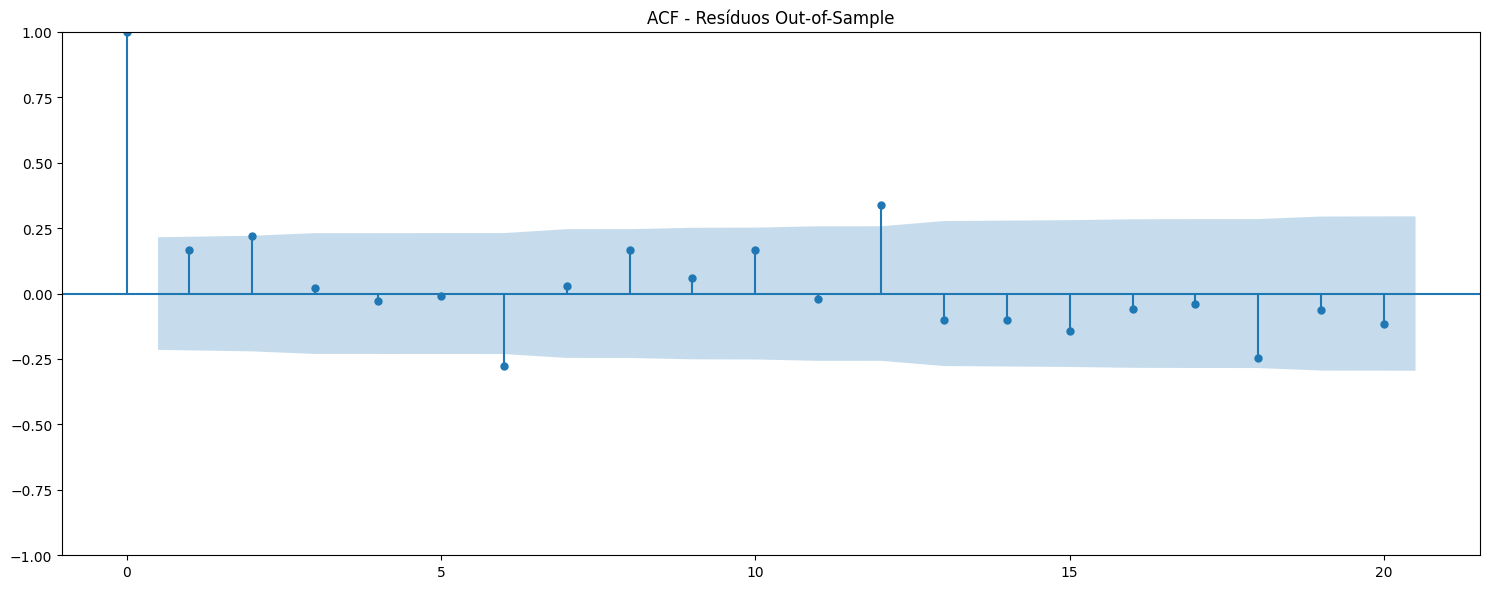


Pipeline finalizado!
Tempo total de execução: 0.09 minutos


In [ ]:
resultado_arima_2_0_2 = rodar_modelo_arima(y_train, y_test, order=(2,0,2), nome_modelo="ARIMA(2,0,2)")

### **5.2.5. AUTO ARIMA**

#### **5.2.5.1. AUTO ARIMA SEM SAZONALIDADE**

In [ ]:
model_AutoARIMA = Pipeline(
    [
        ##('boxcox', BoxCoxEndogTransformer()),
        (
            "auto - arima",
            pm.AutoARIMA(d=0,
                trace=True,
                suppress_warnings=True,
                max_p=2,
                max_q=3,
                stepwise=True,
                seasonal=False,
                m=12,
            ),
        )
    ]
)

model_AutoARIMA.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=207.892, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=342.087, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=279.902, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=202.345, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=340.087, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=203.893, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=203.896, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=205.893, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=200.473, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=202.038, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=202.040, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=277.904, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=204.038, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 0.779 seconds


Pipeline(steps=[('auto - arima',
                 AutoARIMA(m=6, max_p=2, seasonal=False, trace=True))])

#### **5.2.5.1. AUTO ARIMA COM SAZONALIDADE**

In [191]:
model_AutoARIMA = Pipeline(
    [
        ##('boxcox', BoxCoxEndogTransformer()),
        (
            "auto - arima",
            pm.AutoARIMA(
                trace=True,
                suppress_warnings=True,
                max_p=2,
                stepwise=True,
                seasonal=True,
                m=6,
            ),
        )
    ]
)

model_AutoARIMA.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=342.087, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=277.841, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=204.295, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=340.087, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[6] intercept   : AIC=202.345, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[6] intercept   : AIC=204.221, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[6] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[6] intercept   : AIC=203.893, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[6] intercept   : AIC=203.896, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=279.902, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[6] intercept   : AIC=205.893, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[6]             : AIC=200.473, Time=0.03 sec
 ARIMA(0,1,1)(1,0,0)[6]             : AIC=202.347, Time=0.05 sec
 ARIMA(0,1,1)(0,0,1)[6]             : AIC=202.422, Time

Pipeline(steps=[('auto - arima', AutoARIMA(m=6, max_p=2, trace=True))])